In [50]:
# Bring in the libraries
import os
import warnings
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Important for classifer models
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import svm
# Classification KPIs
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

# Vis
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline

In [2]:
os.chdir(r'..\UFC-Predictions\Data')

In [3]:
# Load in data

recent_events = pd.read_csv('most-recent-event.csv')
master = pd.read_csv('ufc-master.csv')
upcoming_events = pd.read_csv('upcoming-event.csv')
# Probs won't use
task_dummy = pd.read_csv('task-dummy.csv')

In [4]:
# Quick peak at upcoming events
upcoming_events[['total_round_dif','total_title_bout_dif','ko_dif','sub_dif','height_dif','reach_dif','age_dif','sig_str_dif',
                        'avg_sub_att_dif','avg_td_dif']].tail(20)

,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif
0,59,13,14,3,5.08,-5.08,9,-0.27,0.6,-0.23
1,27,0,3,-1,2.54,10.16,4,1.85,-2.5,0.58
2,4,0,3,-2,-5.08,0.00,-2,0.17,-0.7,0.00
3,-24,0,-2,-1,-2.54,-7.62,2,-4.69,-0.8,-0.96
4,-41,0,0,-2,-2.54,-2.54,-9,-2.45,1.2,-0.43
5,0,0,-1,0,2.54,10.16,-6,-3.95,0.0,2.15
6,-1,0,-1,0,-5.08,-12.70,2,-10.77,0.0,0.00
7,-10,0,-1,-1,-2.54,-7.62,1,-1.70,-0.5,-1.37
8,0,0,0,0,-5.08,-7.62,-3,1.73,0.0,0.00
9,5,0,0,1,2.54,10.16,0,-0.07,0.2,-0.06


In [5]:
# Keeping only relevant columns:
master = master[['Winner','title_bout','weight_class','gender','no_of_rounds','B_current_lose_streak',
                         'B_current_win_streak','B_draw','B_avg_SIG_STR_landed','B_avg_SIG_STR_pct','B_avg_SUB_ATT',
                        'B_avg_TD_landed','B_avg_TD_pct','B_longest_win_streak','B_wins','B_losses','B_total_rounds_fought',
                        'B_total_title_bouts','B_win_by_Decision_Majority','B_win_by_Decision_Split','B_win_by_Decision_Unanimous',
                        'B_win_by_KO/TKO','B_win_by_Submission','B_win_by_TKO_Doctor_Stoppage','B_Stance','B_Height_cms','B_Reach_cms',
                        'B_Weight_lbs',
                         
                         'R_current_lose_streak',
                         'R_current_win_streak','R_draw','R_avg_SIG_STR_landed','R_avg_SIG_STR_pct','R_avg_SUB_ATT',
                        'R_avg_TD_landed','R_avg_TD_pct','R_longest_win_streak','R_wins','R_losses','R_total_rounds_fought',
                        'R_total_title_bouts','R_win_by_Decision_Majority','R_win_by_Decision_Split','R_win_by_Decision_Unanimous',
                        'R_win_by_KO/TKO','R_win_by_Submission','R_win_by_TKO_Doctor_Stoppage','R_Stance','R_Height_cms','R_Reach_cms',
                        'R_Weight_lbs','R_age','B_age','lose_streak_dif','win_streak_dif','longest_win_streak_dif','win_dif','loss_dif',
                        'total_round_dif','total_title_bout_dif','ko_dif','sub_dif','height_dif','reach_dif','age_dif','sig_str_dif',
                        'avg_sub_att_dif','avg_td_dif','B_match_weightclass_rank','R_match_weightclass_rank','better_rank','finish',
                         # can use finish info and round stop for round end model
                        'finish_details','finish_round','finish_round_time','total_fight_time_secs']]

In [6]:
master.head()

,Winner,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,...,avg_sub_att_dif,avg_td_dif,B_match_weightclass_rank,R_match_weightclass_rank,better_rank,finish,finish_details,finish_round,finish_round_time,total_fight_time_secs
0,Red,True,Lightweight,MALE,5,0,4,0,7.74,0.59,...,-0.7,-5.35,1.0,0.0,Red,NaN,NaN,NaN,NaN,NaN
1,Red,False,Middleweight,MALE,3,0,3,0,3.72,0.51,...,0.0,-0.28,2.0,1.0,Red,NaN,NaN,NaN,NaN,NaN
2,Red,False,Heavyweight,MALE,3,1,0,0,2.97,0.39,...,0.0,-0.40,10.0,7.0,Red,NaN,NaN,NaN,NaN,NaN
3,Blue,False,Middleweight,MALE,3,0,1,0,3.47,0.46,...,0.0,1.74,NaN,NaN,neither,NaN,NaN,NaN,NaN,NaN
4,Red,False,Women's Flyweight,FEMALE,3,0,0,0,0.00,0.00,...,0.0,-1.14,NaN,5.0,Red,NaN,NaN,NaN,NaN,NaN


In [7]:
# Looking at data types and evaluating what needs to be transformed
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4443 entries, 0 to 4442
Data columns (total 76 columns):
Winner                          4443 non-null object
title_bout                      4443 non-null bool
weight_class                    4443 non-null object
gender                          4443 non-null object
no_of_rounds                    4443 non-null int64
B_current_lose_streak           4443 non-null int64
B_current_win_streak            4443 non-null int64
B_draw                          4443 non-null int64
B_avg_SIG_STR_landed            3513 non-null float64
B_avg_SIG_STR_pct               3678 non-null float64
B_avg_SUB_ATT                   3611 non-null float64
B_avg_TD_landed                 3610 non-null float64
B_avg_TD_pct                    3601 non-null float64
B_longest_win_streak            4443 non-null int64
B_wins                          4443 non-null int64
B_losses                        4443 non-null int64
B_total_rounds_fought           4443 non-null int

## Consolidating and Creating Variables

In [8]:
# Making concise victory conditions:

#Decision:
master['B_win_by_Decision'] = master['B_win_by_Decision_Majority'] + master['B_win_by_Decision_Split'] + master['B_win_by_Decision_Unanimous']
master['R_win_by_Decision'] = master['R_win_by_Decision_Majority'] + master['R_win_by_Decision_Split'] + master['R_win_by_Decision_Unanimous']
master = master.drop(['B_win_by_Decision_Majority','B_win_by_Decision_Split','B_win_by_Decision_Unanimous','R_win_by_Decision_Majority','R_win_by_Decision_Split','R_win_by_Decision_Unanimous'],axis=1)

# KO
master['B_win_by_KO'] = master['B_win_by_KO/TKO'] + master['B_win_by_TKO_Doctor_Stoppage']
master['R_win_by_KO'] = master['R_win_by_KO/TKO'] + master['R_win_by_TKO_Doctor_Stoppage']
master = master.drop(['B_win_by_KO/TKO','B_win_by_TKO_Doctor_Stoppage','R_win_by_KO/TKO','R_win_by_TKO_Doctor_Stoppage'],axis=1)

In [9]:
# Creating Additional dif variables:
master['rank_dif'] = master['B_match_weightclass_rank'] - master['R_match_weightclass_rank']
master['weight_lbs_dif'] = master['B_Weight_lbs'] - master['R_Weight_lbs']

## Adjusting Categorical Vars

In [10]:
# Cleaning up stances
master['B_Stance'].value_counts()

Orthodox       3344
Southpaw        900
Switch          197
Switch            1
Open Stance       1
Name: B_Stance, dtype: int64

In [11]:
master['R_Stance'].value_counts()

Orthodox       3389
Southpaw        898
Switch          152
Open Stance       4
Name: R_Stance, dtype: int64

In [12]:
master['B_Stance'].replace(r' ','',regex=True,inplace=True)

In [13]:
master['B_Stance'].value_counts()

Orthodox      3344
Southpaw       900
Switch         198
OpenStance       1
Name: B_Stance, dtype: int64

In [14]:
# Stances
master_cat = master[['B_Stance','R_Stance']]
master_cat_dummy = pd.get_dummies(master_cat)
# Bring back together and remove old
master = master.merge(master_cat_dummy, left_index=True,right_index=True)
master = master.drop(['B_Stance','R_Stance'],axis=1)

In [15]:
# Clear up the NaN and view
master = master.replace(np.nan, 0)
master.head()

,Winner,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,...,rank_dif,weight_lbs_dif,B_Stance_OpenStance,B_Stance_Orthodox,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
0,Red,True,Lightweight,MALE,5,0,4,0,7.74,0.59,...,1.0,0,0,1,0,0,0,1,0,0
1,Red,False,Middleweight,MALE,3,0,3,0,3.72,0.51,...,1.0,0,0,0,0,1,0,1,0,0
2,Red,False,Heavyweight,MALE,3,1,0,0,2.97,0.39,...,3.0,0,0,0,1,0,0,1,0,0
3,Blue,False,Middleweight,MALE,3,0,1,0,3.47,0.46,...,0.0,0,0,1,0,0,0,1,0,0
4,Red,False,Women's Flyweight,FEMALE,3,0,0,0,0.00,0.00,...,0.0,0,0,1,0,0,0,1,0,0


In [16]:
# Split up the genders:
m_master = master[master['gender'] == 'MALE']
m_master = m_master.drop(['gender'], axis = 1)
f_master = master[master['gender'] == 'FEMALE']
f_master = f_master.drop(['gender'], axis = 1)

In [17]:
m_master.head()

,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,...,rank_dif,weight_lbs_dif,B_Stance_OpenStance,B_Stance_Orthodox,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
0,Red,True,Lightweight,5,0,4,0,7.74,0.59,0.0,...,1.0,0,0,1,0,0,0,1,0,0
1,Red,False,Middleweight,3,0,3,0,3.72,0.51,0.0,...,1.0,0,0,0,0,1,0,1,0,0
2,Red,False,Heavyweight,3,1,0,0,2.97,0.39,0.2,...,3.0,0,0,0,1,0,0,1,0,0
3,Blue,False,Middleweight,3,0,1,0,3.47,0.46,0.0,...,0.0,0,0,1,0,0,0,1,0,0
5,Red,False,Light Heavyweight,3,1,0,0,5.29,0.39,0.0,...,0.0,0,0,0,1,0,0,1,0,0


In [18]:
f_master.head()

,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,...,rank_dif,weight_lbs_dif,B_Stance_OpenStance,B_Stance_Orthodox,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
4,Red,False,Women's Flyweight,3,0,0,0,0.00,0.00,0.0,...,0.0,0,0,1,0,0,0,1,0,0
9,Blue,False,Women's Flyweight,3,0,0,0,0.00,0.00,0.0,...,0.0,0,0,0,1,0,0,1,0,0
12,Blue,False,Women's Flyweight,3,2,0,0,6.40,0.49,0.4,...,1.0,-10,0,1,0,0,0,1,0,0
17,Red,False,Women's Flyweight,3,0,1,0,3.65,0.58,0.0,...,0.0,-10,0,1,0,0,0,1,0,0
33,Red,False,Women's Bantamweight,3,0,0,0,0.00,0.00,0.0,...,0.0,0,0,1,0,0,0,1,0,0


In [19]:
# Title_bout / # of total rounds? Would that be necessary or is it alright as is?

In [20]:
# Methods of victory

# Winner Model:
* Utilizes binary classfication models
* Old Work: https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/a7f894ab-27b9-4075-9131-5f706ca2b602/view?projectid=7de0f00d-a114-4cd1-a5ae-ef5f4ca012b5&context=cpdaas

In [21]:
# Creating different potentially important datasets


# Base Stats
m_winner_base = m_master[['weight_class','Winner','B_current_lose_streak',
                         'B_current_win_streak','B_draw','B_avg_SIG_STR_landed','B_avg_SIG_STR_pct','B_avg_SUB_ATT',
                        'B_avg_TD_landed','B_avg_TD_pct','B_wins','B_losses','B_total_rounds_fought',
                        'B_total_title_bouts','B_Height_cms','B_Reach_cms','B_age',
                        'B_Weight_lbs','B_win_by_Decision','B_win_by_KO','B_Weight_lbs','B_match_weightclass_rank',
                              
                        'R_current_lose_streak',
                         'R_current_win_streak','R_draw','R_avg_SIG_STR_landed','R_avg_SIG_STR_pct','R_avg_SUB_ATT',
                        'R_avg_TD_landed','R_avg_TD_pct','R_wins','R_losses','R_total_rounds_fought',
                        'R_total_title_bouts','R_Height_cms','R_Reach_cms','R_age',
                        'R_Weight_lbs','R_win_by_Decision','R_win_by_KO','R_Weight_lbs','R_match_weightclass_rank']]

# Fighter differences
m_winner_difs = m_master[['weight_class','Winner','lose_streak_dif','win_streak_dif','longest_win_streak_dif','win_dif','loss_dif',
                        'total_round_dif','total_title_bout_dif','ko_dif','sub_dif','height_dif','reach_dif','age_dif','sig_str_dif',
                        'avg_sub_att_dif','avg_td_dif','rank_dif','weight_lbs_dif']]



fighter_columns = ['weight_class','Winner','current_lose_streak',
                         'current_win_streak','draw','avg_SIG_STR_landed','avg_SIG_STR_pct','avg_SUB_ATT',
                        'avg_TD_landed','avg_TD_pct','wins','losses','total_rounds_fought',
                        'total_title_bouts','Height_cms','Reach_cms', 'Age',
                        'Weight_lbs','win_by_Decision','win_by_KO','Weight_lbs','match_weightclass_rank']

# Blue fighter stats
m_winner_bf = m_master[['weight_class','Winner','B_current_lose_streak',
                         'B_current_win_streak','B_draw','B_avg_SIG_STR_landed','B_avg_SIG_STR_pct','B_avg_SUB_ATT',
                        'B_avg_TD_landed','B_avg_TD_pct','B_wins','B_losses','B_total_rounds_fought',
                        'B_total_title_bouts','B_Height_cms','B_Reach_cms', 'B_age',
                        'B_Weight_lbs','B_win_by_Decision','B_win_by_KO','B_Weight_lbs','B_match_weightclass_rank']]

m_winner_bf.columns = fighter_columns

# Red winners' stats 
m_winner_rf = m_master[['weight_class','Winner','R_current_lose_streak',
                         'R_current_win_streak','R_draw','R_avg_SIG_STR_landed','R_avg_SIG_STR_pct','R_avg_SUB_ATT',
                        'R_avg_TD_landed','R_avg_TD_pct','R_wins','R_losses','R_total_rounds_fought',
                        'R_total_title_bouts','R_Height_cms','R_Reach_cms', 'R_age',
                        'R_Weight_lbs','R_win_by_Decision','R_win_by_KO','R_Weight_lbs','R_match_weightclass_rank']]

m_winner_rf.columns = fighter_columns

# Final clean up

# Blue
m_winner_bw = m_winner_bf[m_winner_bf['Winner'] == 'Blue']
m_winner_bw = m_winner_bw.drop(['Winner'], axis = 1)

# Red
m_winner_rw = m_winner_rf[m_winner_rf['Winner'] == 'Red']
m_winner_rw = m_winner_rw.drop(['Winner'], axis = 1)

In [22]:
# Base
m_winner_base.head()

,weight_class,Winner,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_landed,B_avg_TD_pct,...,R_total_rounds_fought,R_total_title_bouts,R_Height_cms,R_Reach_cms,R_age,R_Weight_lbs,R_win_by_Decision,R_win_by_KO,R_Weight_lbs,R_match_weightclass_rank
0,Lightweight,Red,0,4,0,7.74,0.59,0.0,0.00,0.00,...,36,3,177.80,177.80,32,155,6,2,155,0.0
1,Middleweight,Red,0,3,0,3.72,0.51,0.0,0.18,0.33,...,42,2,182.88,185.42,29,185,7,5,185,1.0
2,Heavyweight,Red,1,0,0,2.97,0.39,0.2,0.32,0.33,...,24,0,200.66,203.20,32,250,3,2,250,7.0
3,Middleweight,Blue,0,1,0,3.47,0.46,0.0,1.74,0.14,...,0,0,175.26,185.42,25,185,0,0,185,0.0
5,Light Heavyweight,Red,1,0,0,5.29,0.39,0.0,2.59,0.71,...,11,0,190.50,190.50,28,205,1,3,205,11.0


In [23]:
# Difs
m_winner_difs.head()

,weight_class,Winner,lose_streak_dif,win_streak_dif,longest_win_streak_dif,win_dif,loss_dif,total_round_dif,total_title_bout_dif,ko_dif,sub_dif,height_dif,reach_dif,age_dif,sig_str_dif,avg_sub_att_dif,avg_td_dif,rank_dif,weight_lbs_dif
0,Lightweight,Red,0,-8,-8,-7,2,-19,-2,3,-4,2.54,0.00,-1,3.63,-0.7,-5.35,1.0,0
1,Middleweight,Red,0,2,-6,-6,1,-22,-2,0,0,-2.54,10.16,7,-0.79,0.0,-0.28,1.0,0
2,Heavyweight,Red,0,0,-1,1,5,0,0,4,0,-5.08,-7.62,5,-1.68,0.0,-0.40,3.0,0
3,Middleweight,Blue,0,1,1,1,1,3,0,1,0,7.62,10.16,6,3.47,0.0,1.74,0.0,0
5,Light Heavyweight,Red,1,-4,-2,0,3,4,0,0,0,-5.08,0.00,-2,1.83,0.0,1.91,0.0,0


In [24]:
# Blue Winners
m_winner_bw.head()

,weight_class,current_lose_streak,current_win_streak,draw,avg_SIG_STR_landed,avg_SIG_STR_pct,avg_SUB_ATT,avg_TD_landed,avg_TD_pct,wins,...,total_rounds_fought,total_title_bouts,Height_cms,Reach_cms,Age,Weight_lbs,win_by_Decision,win_by_KO,Weight_lbs,match_weightclass_rank
3,Middleweight,0,1,0,3.47,0.46,0.0,1.74,0.14,1,...,3,0,182.88,195.58,31,185,0,1,185,0.0
6,Heavyweight,3,0,0,4.09,0.48,0.0,0.00,0.00,3,...,12,0,187.96,190.50,27,264,1,2,264,0.0
7,Catch Weight,0,2,0,4.25,0.42,0.6,1.13,0.46,5,...,19,0,170.18,172.72,29,140,4,0,140,0.0
8,Welterweight,0,0,0,0.00,0.00,0.0,0.00,0.00,0,...,0,0,185.42,195.58,26,170,0,0,170,0.0
14,Welterweight,1,0,0,4.65,0.48,1.0,1.05,0.18,8,...,33,0,187.96,185.42,34,170,3,3,170,0.0


In [25]:
# Red Winners
m_winner_rw.head()

,weight_class,current_lose_streak,current_win_streak,draw,avg_SIG_STR_landed,avg_SIG_STR_pct,avg_SUB_ATT,avg_TD_landed,avg_TD_pct,wins,...,total_rounds_fought,total_title_bouts,Height_cms,Reach_cms,Age,Weight_lbs,win_by_Decision,win_by_KO,Weight_lbs,match_weightclass_rank
0,Lightweight,0,12,0,4.11,0.49,0.7,5.35,0.47,12,...,36,3,177.80,177.80,32,155,6,2,155,0.0
1,Middleweight,0,1,0,4.51,0.40,0.0,0.46,0.30,12,...,42,2,182.88,185.42,29,185,7,5,185,1.0
2,Heavyweight,1,0,0,4.65,0.58,0.2,0.72,0.70,5,...,24,0,200.66,203.20,32,250,3,2,250,7.0
5,Light Heavyweight,0,4,0,3.46,0.56,0.0,0.68,0.33,4,...,11,0,190.50,190.50,28,205,1,3,205,11.0
10,Lightweight,0,2,0,3.03,0.36,0.6,0.00,0.00,2,...,6,0,190.50,195.58,26,155,0,1,155,0.0


## Exploratory Data Analysis (EDA):

In [26]:
# Blue Fighter Records
m_winner_bf[['weight_class','wins','losses','draw']].groupby('weight_class').describe()


wins                                               losses  \
                   count      mean       std  min  25%  50%  75%   max  count   
weight_class                                                                    
Bantamweight       439.0  1.931663  2.523836  0.0  0.0  1.0  3.0  18.0  439.0   
Catch Weight        26.0  2.461538  3.754792  0.0  0.0  1.0  2.0  13.0   26.0   
Featherweight      517.0  2.574468  3.349876  0.0  0.0  1.0  4.0  17.0  517.0   
Flyweight          212.0  2.023585  2.702362  0.0  0.0  1.0  3.0  21.0  212.0   
Heavyweight        347.0  3.285303  4.060509  0.0  0.0  2.0  5.0  22.0  347.0   
Light Heavyweight  361.0  3.531856  3.798349  0.0  0.0  3.0  5.0  19.0  361.0   
Lightweight        803.0  2.992528  3.822097  0.0  0.0  1.0  4.0  23.0  803.0   
Middleweight       535.0  3.269159  3.688031  0.0  0.0  2.0  5.0  19.0  535.0   
Welterweight       772.0  3.238342  3.911496  0.0  0.0  2.0  5.0  29.0  772.0   

                             ...              draw                           \
                       mean  ...  75%   max  count      mean       std  min   
weight_class                 ...                                              
Bantamweight       1.220957  ...  2.0   8.0  439.0  0.002278  0.047727  0.0   
Catch Weight       1.461538  ...  2.0   7.0   26.0  0.000000  0.000000  0.0   
Featherweight      1.700193  ...  2.0  15.0  517.0  0.013540  0.115682  0.0   
Flyweight          1.169811  ...  2.0   6.0  212.0  0.014151  0.118393  0.0   
Heavyweight        1.766571  ...  3.0  10.0  347.0  0.000000  0.000000  0.0   
Light Heavyweight  2.022161  ...  3.0  11.0  361.0  0.000000  0.000000  0.0   
Lightweight        1.836862  ...  3.0  13.0  803.0  0.007472  0.099595  0.0   
Middleweight       1.940187  ...  3.0  10.0  535.0  0.007477  0.086224  0.0   
Welterweight       1.841969  ...  3.0  14.0  772.0  0.001295  0.035991  0.0   

                                       
                   25%  50%  75%  max  
weight_class                           
Bantamweight       0.0  0.0  0.0  1.0  
Catch Weight       0.0  0.0  0.0  0.0  
Featherweight      0.0  0.0  0.0  1.0  
Flyweight          0.0  0.0  0.0  1.0  
Heavyweight        0.0  0.0  0.0  0.0  
Light Heavyweight  0.0  0.0  0.0  0.0  
Lightweight        0.0  0.0  0.0  2.0  
Middleweight       0.0  0.0  0.0  1.0  
Welterweight       0.0  0.0  0.0  1.0  

[9 rows x 24 columns]

In [27]:
# Red Fighters
m_winner_rf[['weight_class','wins','losses','draw']].groupby('weight_class').describe()


wins                                               losses  \
                   count      mean       std  min  25%  50%  75%   max  count   
weight_class                                                                    
Bantamweight       439.0  2.917995  2.957479  0.0  1.0  2.0  4.0  19.0  439.0   
Catch Weight        26.0  4.307692  4.798077  0.0  1.0  3.0  5.0  20.0   26.0   
Featherweight      517.0  3.721470  3.858418  0.0  1.0  2.0  6.0  17.0  517.0   
Flyweight          212.0  3.438679  3.365706  0.0  1.0  3.0  5.0  21.0  212.0   
Heavyweight        347.0  4.976945  4.948234  0.0  1.0  3.0  8.0  32.0  347.0   
Light Heavyweight  361.0  4.642659  4.213373  0.0  1.0  4.0  7.0  26.0  361.0   
Lightweight        803.0  4.679950  4.312995  0.0  1.0  3.0  7.0  29.0  803.0   
Middleweight       535.0  4.476636  4.160960  0.0  1.0  3.0  7.0  20.0  535.0   
Welterweight       772.0  5.068653  4.752412  0.0  1.0  4.0  7.0  22.0  772.0   

                             ...              draw                           \
                       mean  ...  75%   max  count      mean       std  min   
weight_class                 ...                                              
Bantamweight       1.738041  ...  3.0   9.0  439.0  0.002278  0.047727  0.0   
Catch Weight       2.500000  ...  4.5  13.0   26.0  0.038462  0.196116  0.0   
Featherweight      2.110251  ...  3.0  16.0  517.0  0.005803  0.076028  0.0   
Flyweight          1.863208  ...  2.0   9.0  212.0  0.004717  0.068680  0.0   
Heavyweight        2.714697  ...  4.0  17.0  347.0  0.000000  0.000000  0.0   
Light Heavyweight  2.493075  ...  4.0  11.0  361.0  0.005540  0.074329  0.0   
Lightweight        2.645081  ...  4.0  14.0  803.0  0.011208  0.126822  0.0   
Middleweight       2.450467  ...  4.0  11.0  535.0  0.007477  0.086224  0.0   
Welterweight       2.641192  ...  4.0  13.0  772.0  0.006477  0.080269  0.0   

                                       
                   25%  50%  75%  max  
weight_class                           
Bantamweight       0.0  0.0  0.0  1.0  
Catch Weight       0.0  0.0  0.0  1.0  
Featherweight      0.0  0.0  0.0  1.0  
Flyweight          0.0  0.0  0.0  1.0  
Heavyweight        0.0  0.0  0.0  0.0  
Light Heavyweight  0.0  0.0  0.0  1.0  
Lightweight        0.0  0.0  0.0  2.0  
Middleweight       0.0  0.0  0.0  1.0  
Welterweight       0.0  0.0  0.0  1.0  

[9 rows x 24 columns]

In [28]:
# Disregarding caveat, it is okay
warnings.filterwarnings('ignore')

# Blue Fighters
m_winner_bf['Color'] = 'Blue'
m_winner_bf['Win/Loss'] = m_winner_bf['Winner'].apply(lambda x: 'Win' if x == 'Blue' else 'Loss')

# Red Fighters
m_winner_rf['Color'] = 'Red'
m_winner_rf['Win/Loss'] = m_winner_rf['Winner'].apply(lambda x: 'Win' if x == 'Red' else 'Loss')

m_winner_f = pd.concat([m_winner_bf, m_winner_rf])


In [29]:
# All fighters ready for analysis
m_winner_f.head()

,weight_class,Winner,current_lose_streak,current_win_streak,draw,avg_SIG_STR_landed,avg_SIG_STR_pct,avg_SUB_ATT,avg_TD_landed,avg_TD_pct,...,Height_cms,Reach_cms,Age,Weight_lbs,win_by_Decision,win_by_KO,Weight_lbs,match_weightclass_rank,Color,Win/Loss
0,Lightweight,Red,0,4,0,7.74,0.59,0.0,0.00,0.00,...,180.34,177.80,31,155,0,5,155,1.0,Blue,Loss
1,Middleweight,Red,0,3,0,3.72,0.51,0.0,0.18,0.33,...,180.34,195.58,36,185,1,5,185,2.0,Blue,Loss
2,Heavyweight,Red,1,0,0,2.97,0.39,0.2,0.32,0.33,...,195.58,195.58,37,250,0,6,250,10.0,Blue,Loss
3,Middleweight,Blue,0,1,0,3.47,0.46,0.0,1.74,0.14,...,182.88,195.58,31,185,0,1,185,0.0,Blue,Win
5,Light Heavyweight,Red,1,0,0,5.29,0.39,0.0,2.59,0.71,...,185.42,190.50,26,205,1,3,205,0.0,Blue,Loss


In [30]:
# If you prefer using pandas for boxplot

#m_weight_class = m_winner_f.weight_class.unique()

#for wc in m_weight_class:
#    subset = m_winner_f[m_winner_f['weight_class'] == wc]
#    subset.boxplot(by=['Win/Loss','Color'], column=['win_by_KO'])

In [31]:
# Storing the weight_classes for later use
# It will help iterate
m_weight_class = m_winner_f.weight_class.unique()

In [32]:
m_weight_class

array(['Lightweight', 'Middleweight', 'Heavyweight', 'Light Heavyweight',
       'Catch Weight', 'Welterweight', 'Featherweight', 'Bantamweight',
       'Flyweight'], dtype=object)

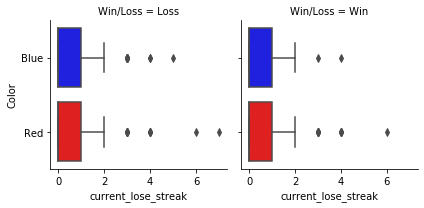

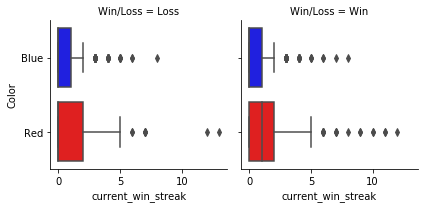

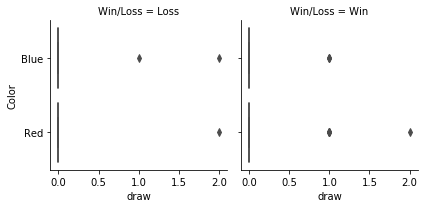

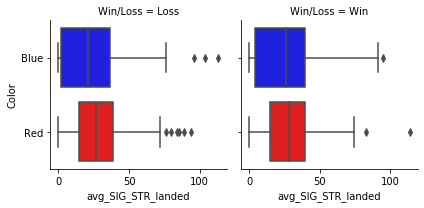

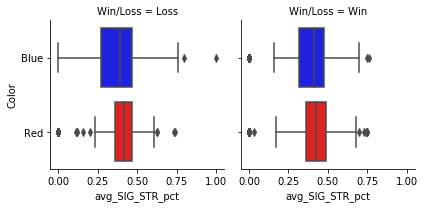

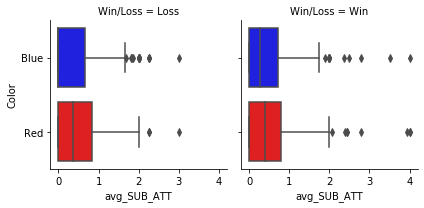

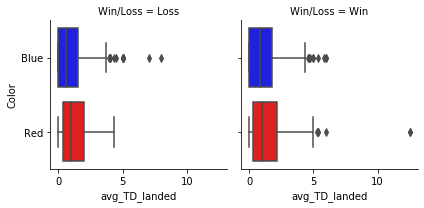

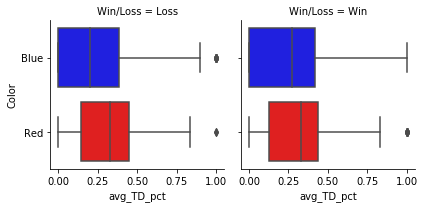

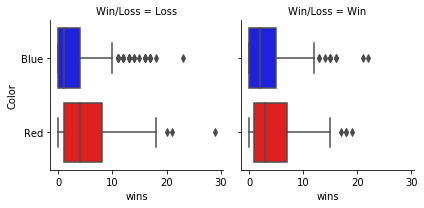

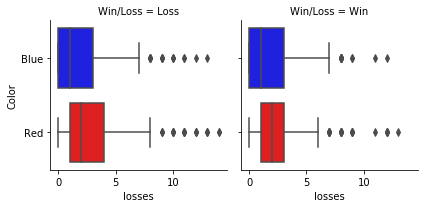

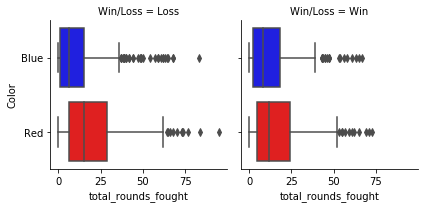

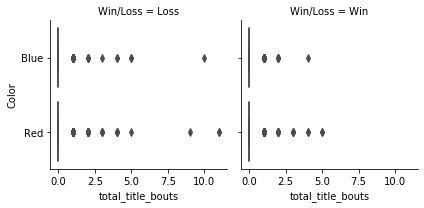

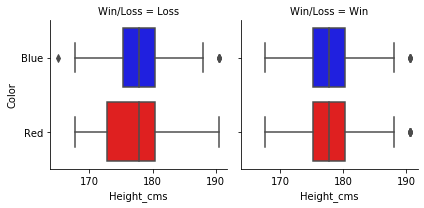

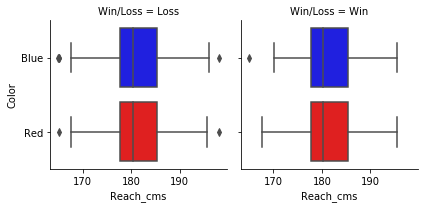

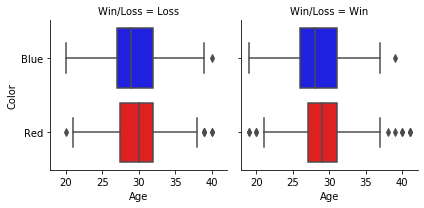

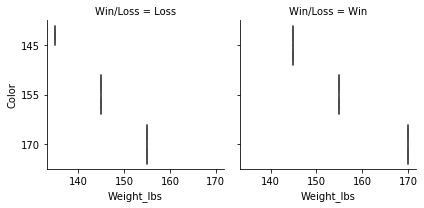

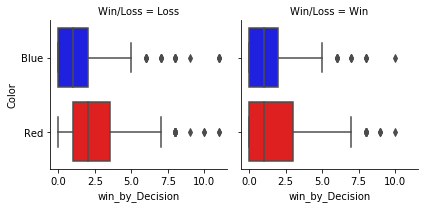

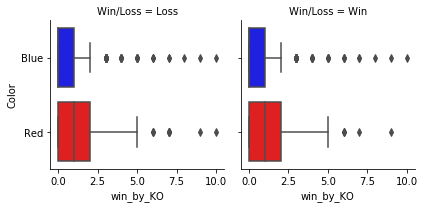

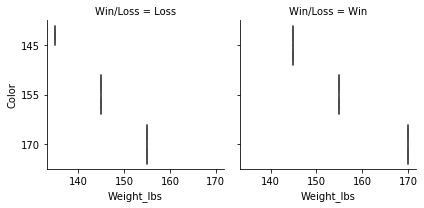

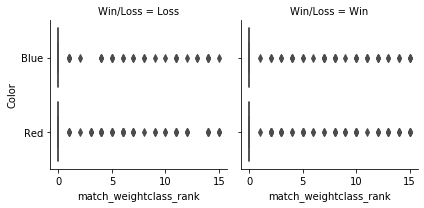

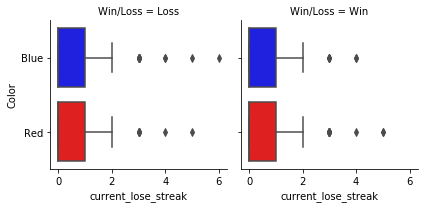

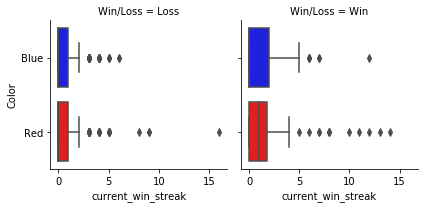

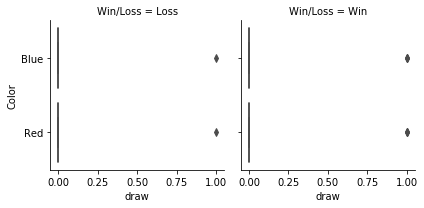

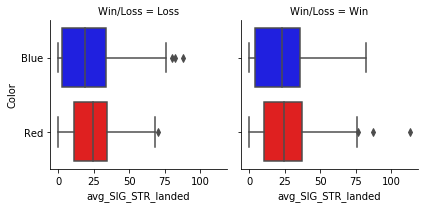

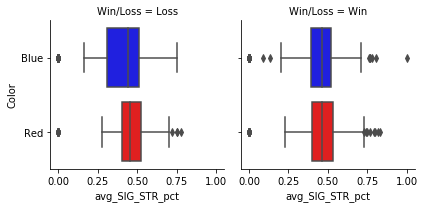

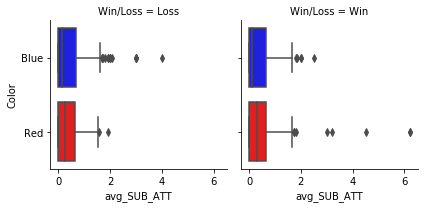

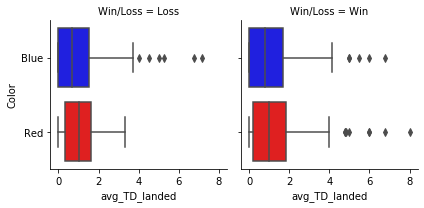

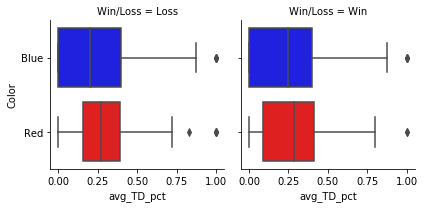

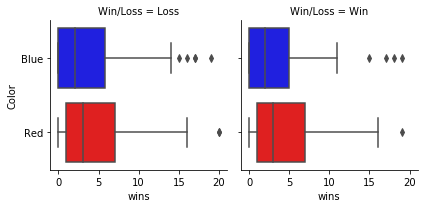

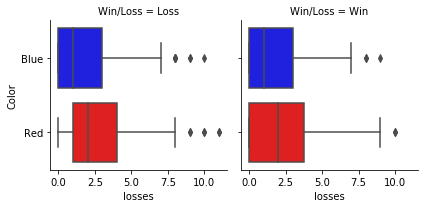

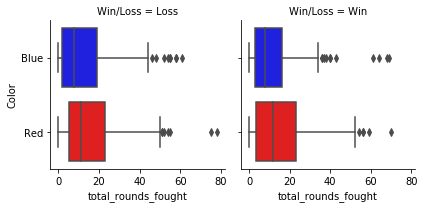

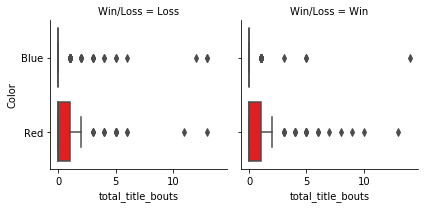

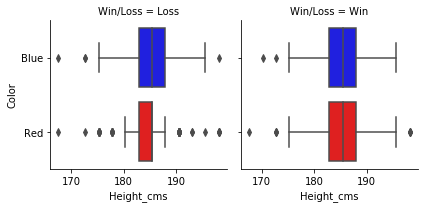

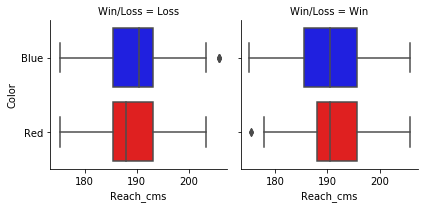

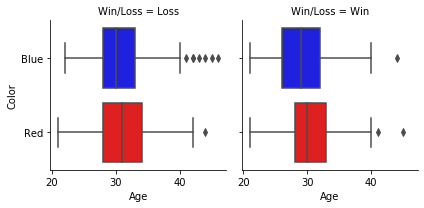

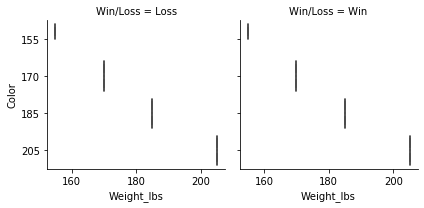

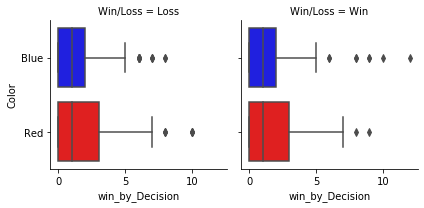

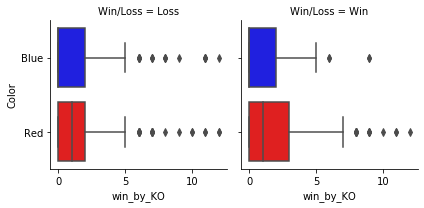

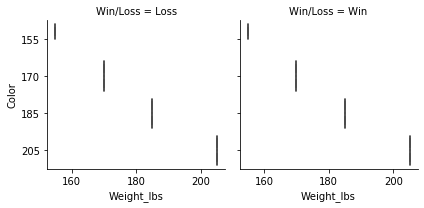

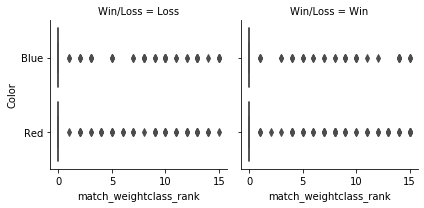

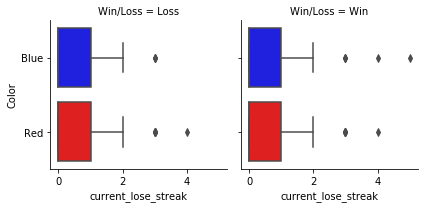

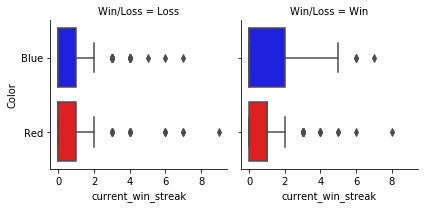

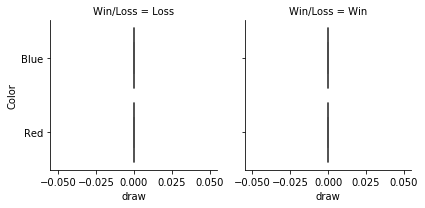

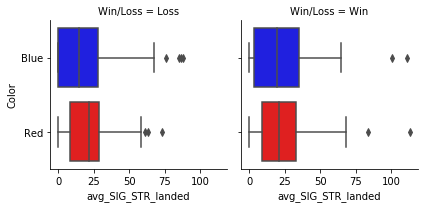

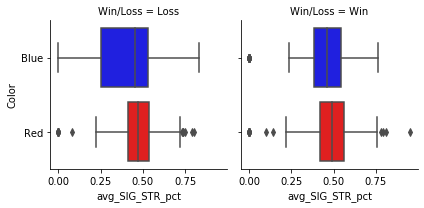

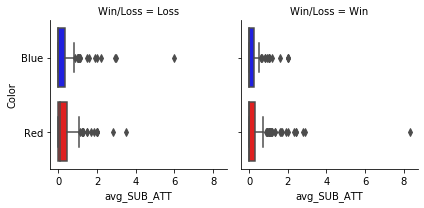

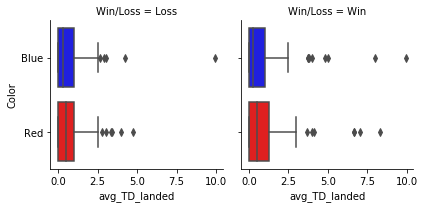

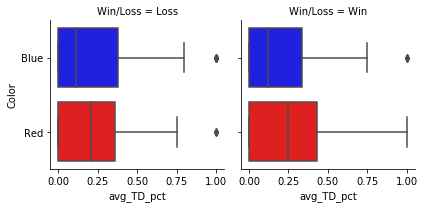

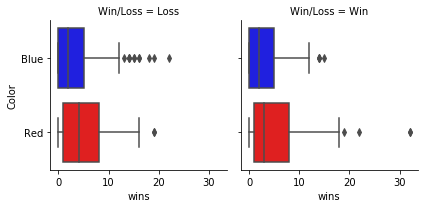

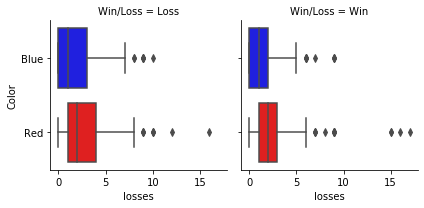

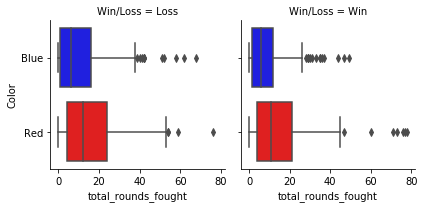

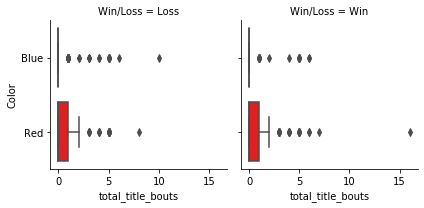

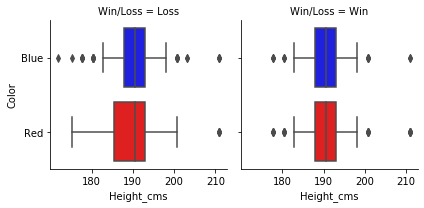

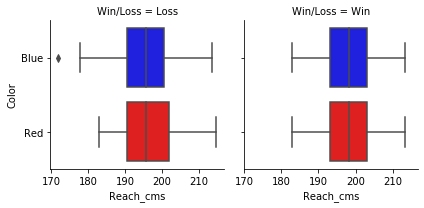

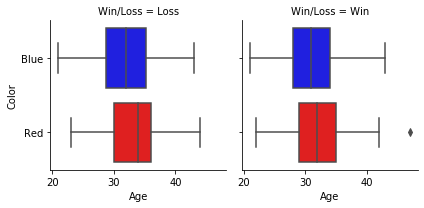

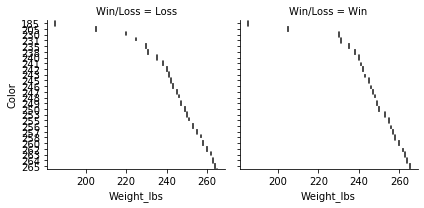

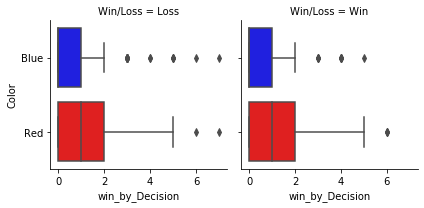

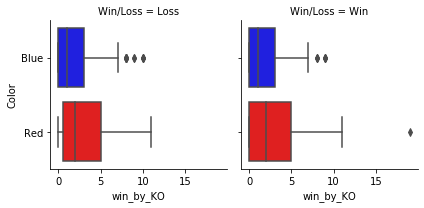

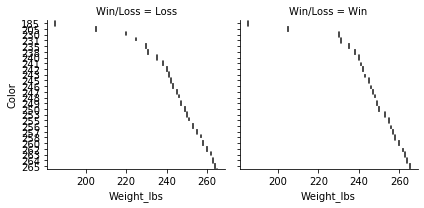

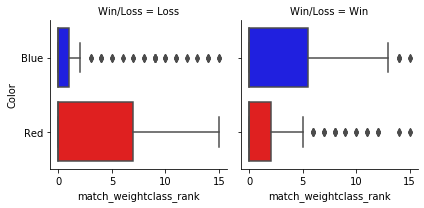

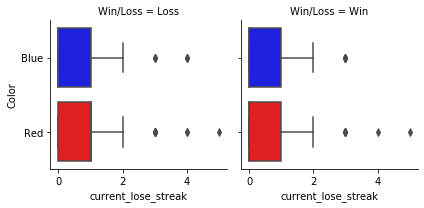

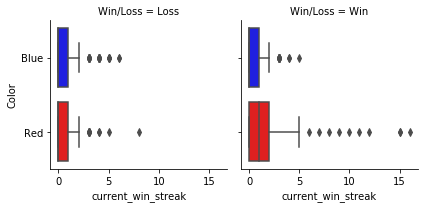

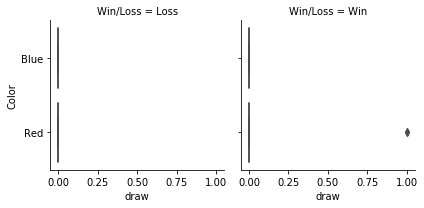

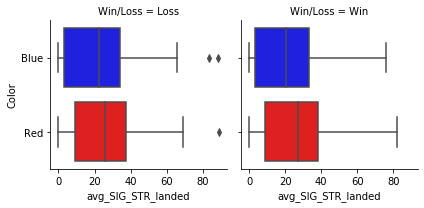

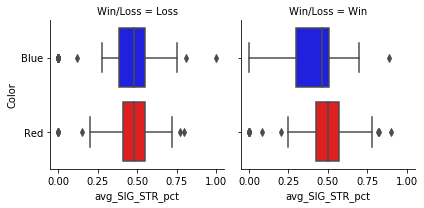

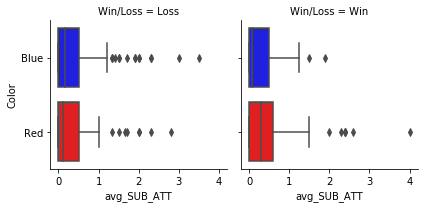

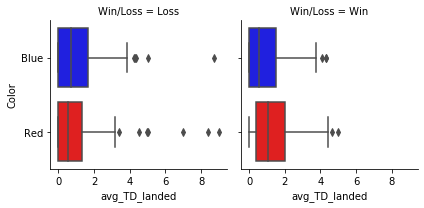

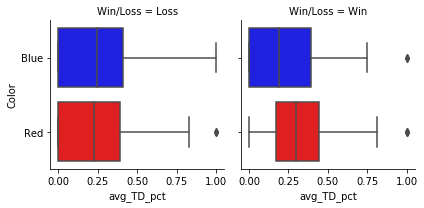

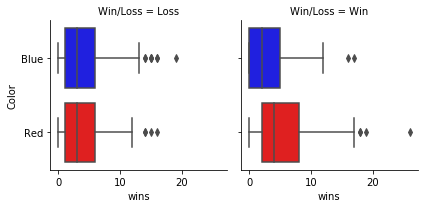

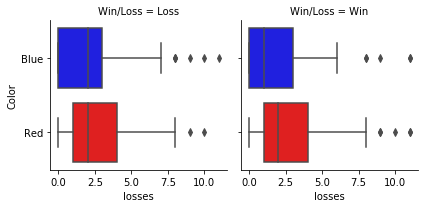

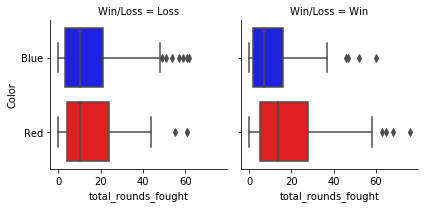

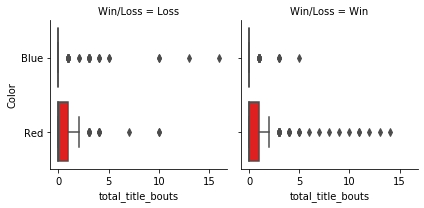

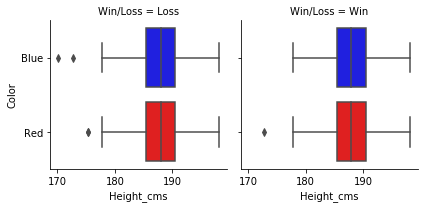

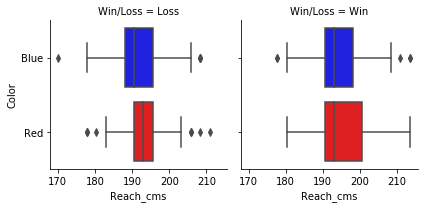

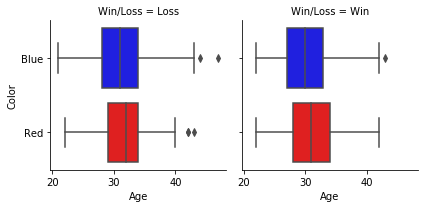

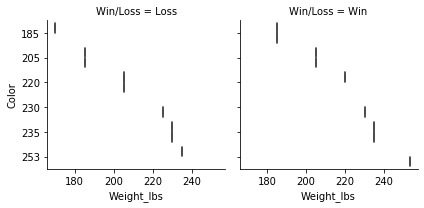

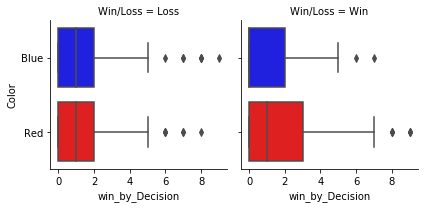

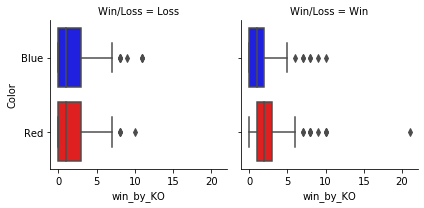

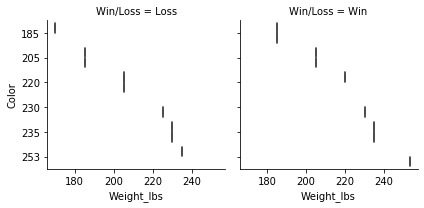

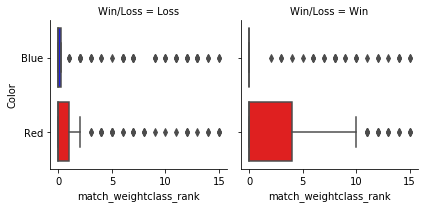

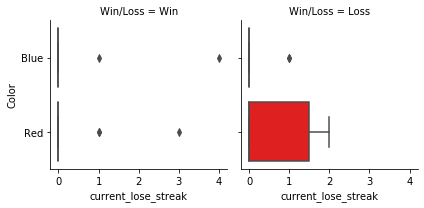

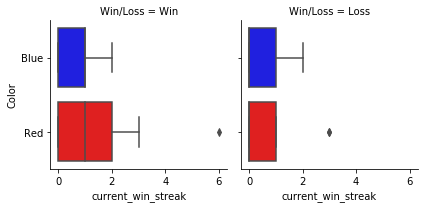

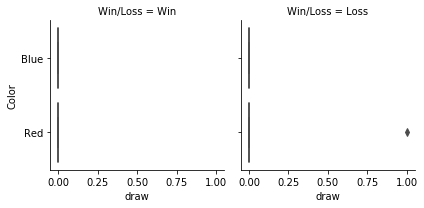

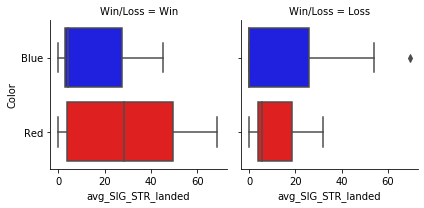

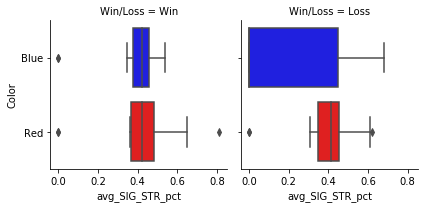

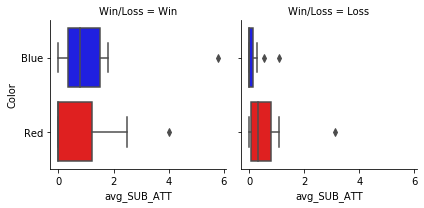

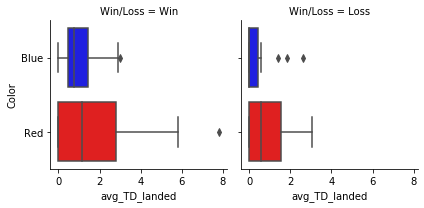

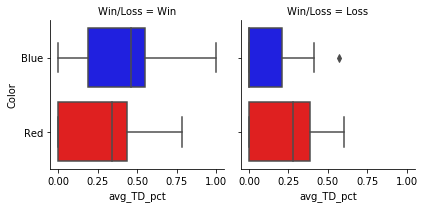

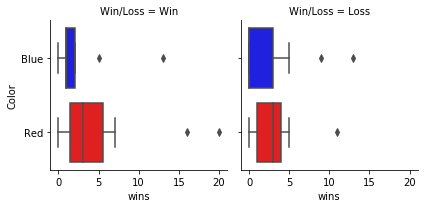

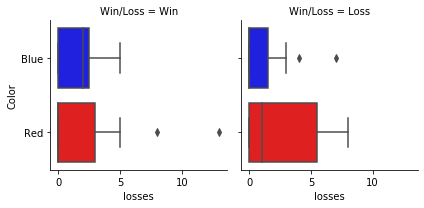

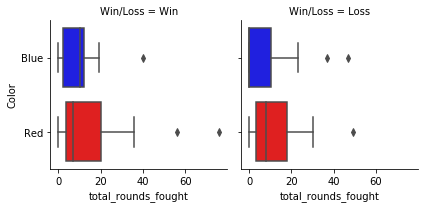

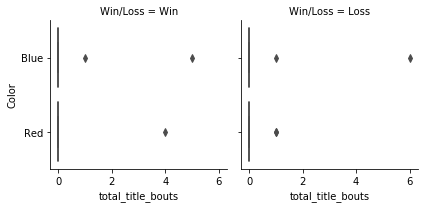

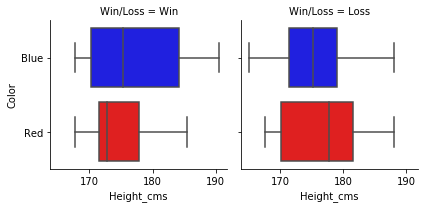

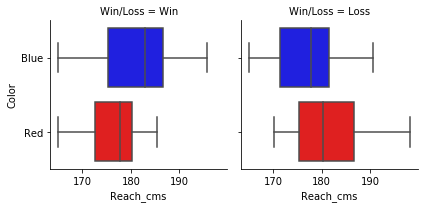

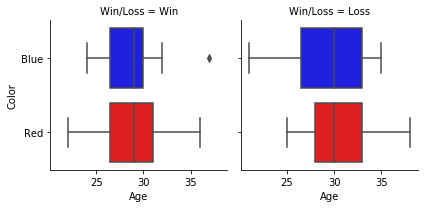

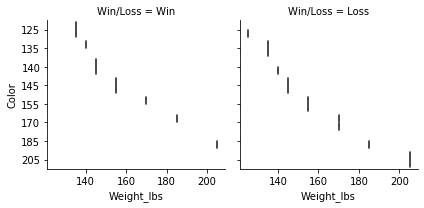

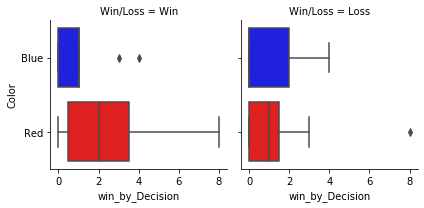

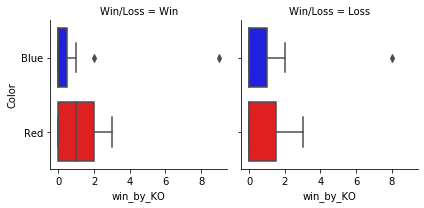

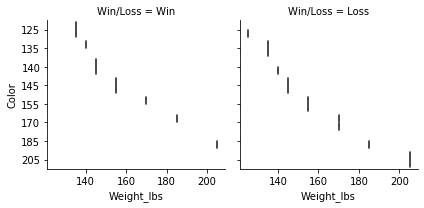

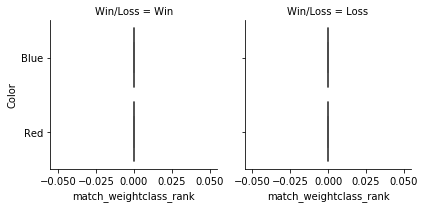

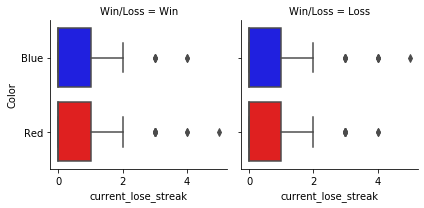

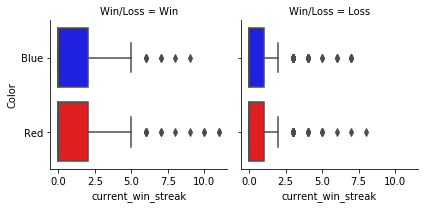

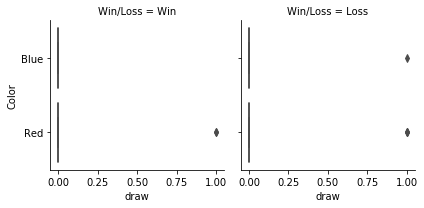

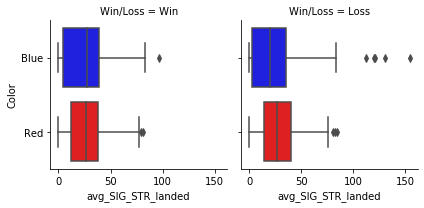

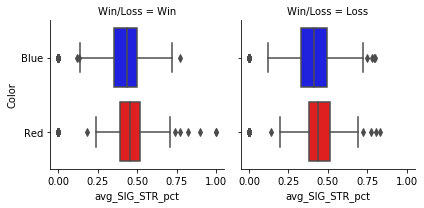

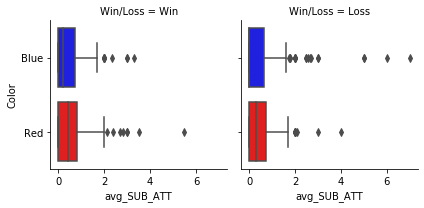

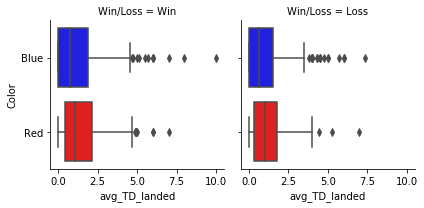

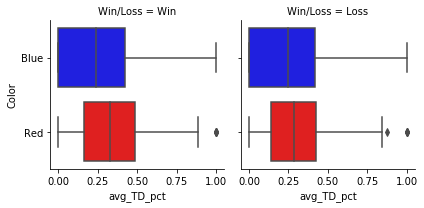

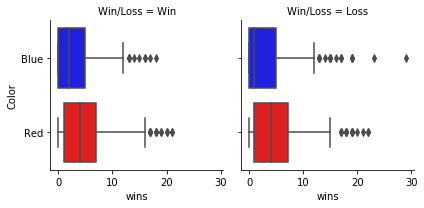

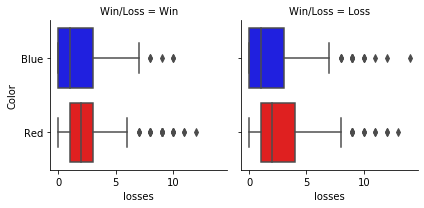

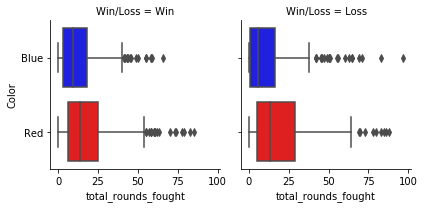

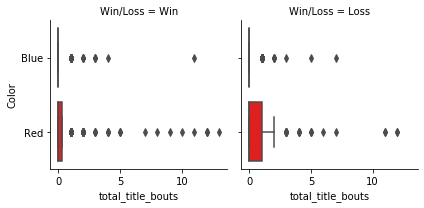

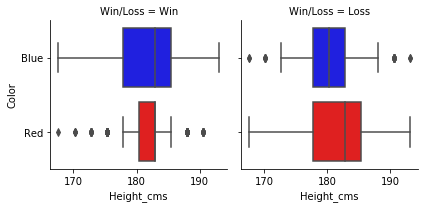

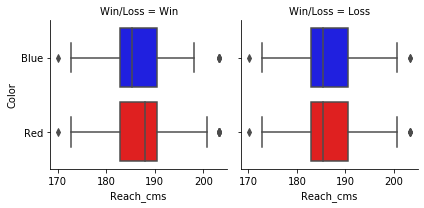

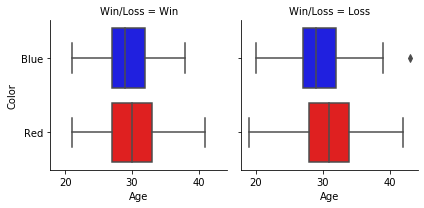

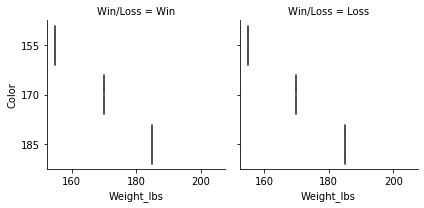

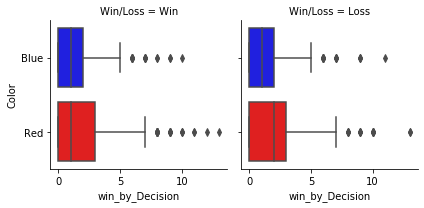

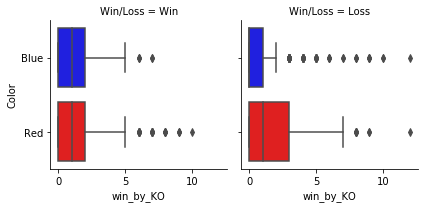

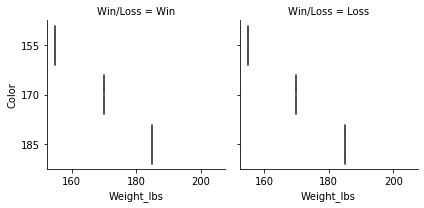

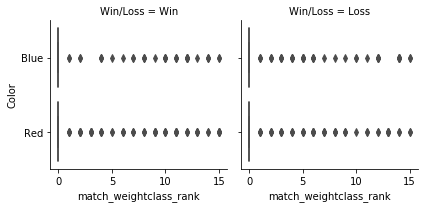

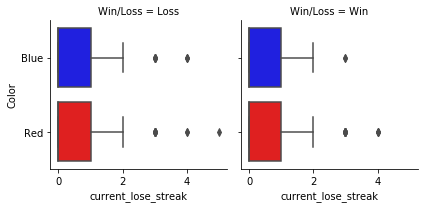

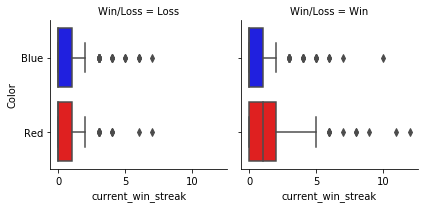

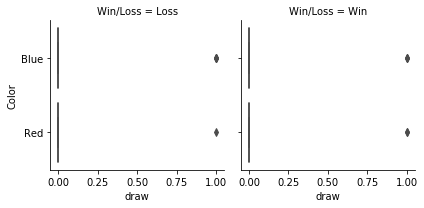

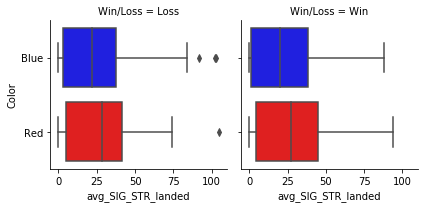

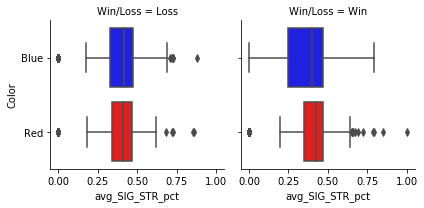

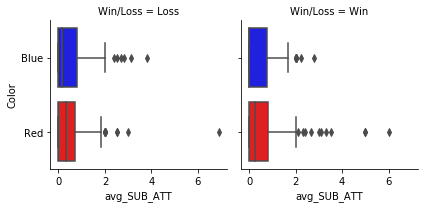

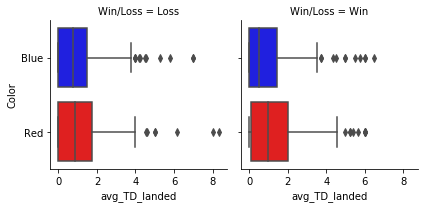

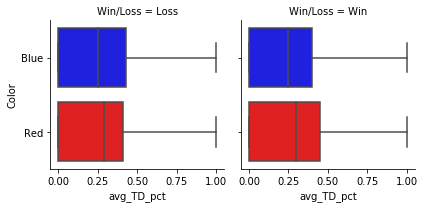

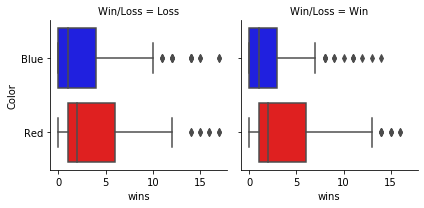

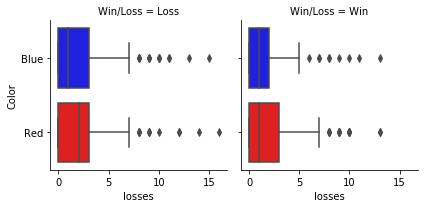

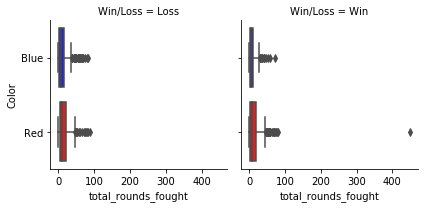

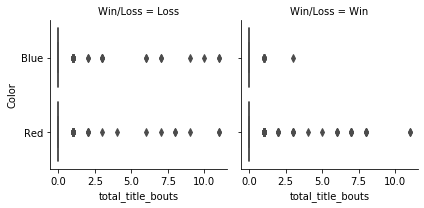

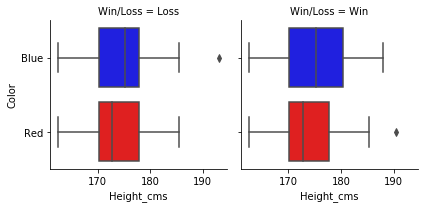

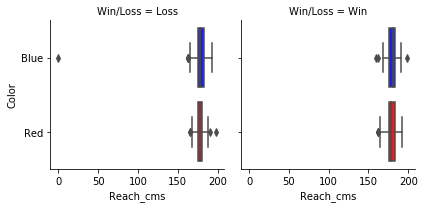

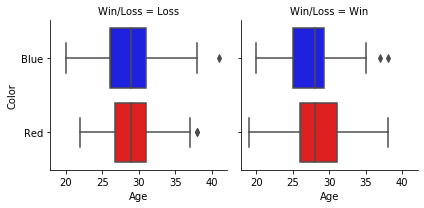

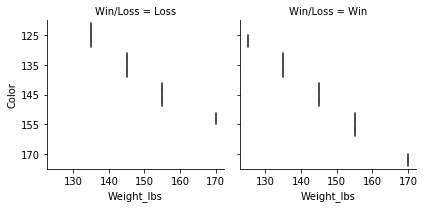

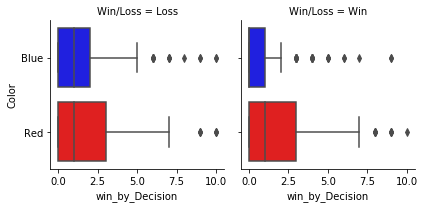

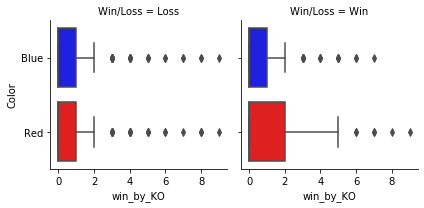

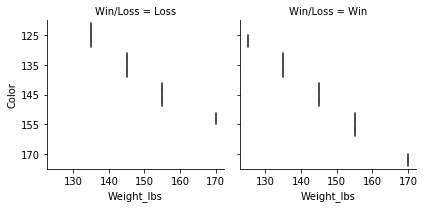

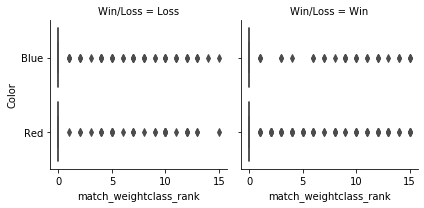

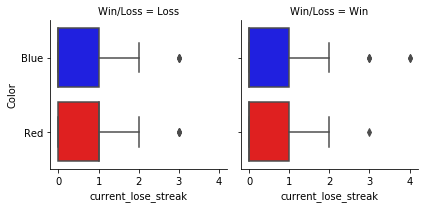

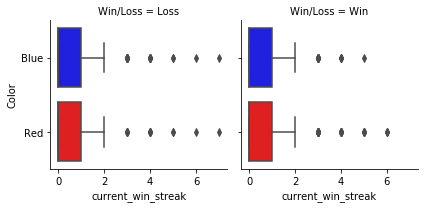

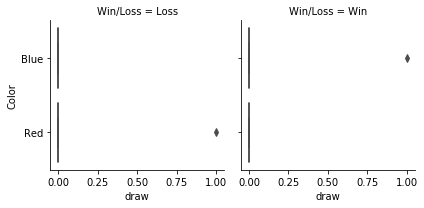

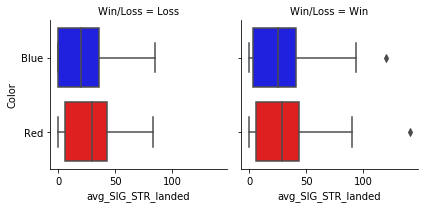

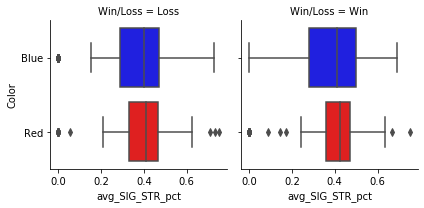

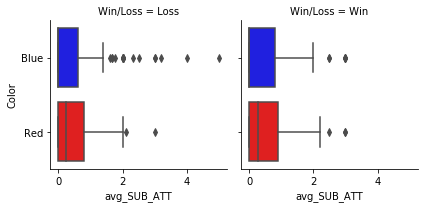

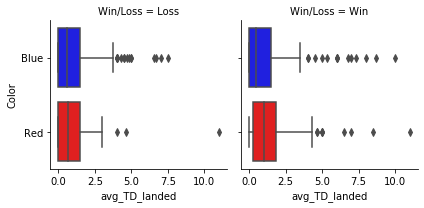

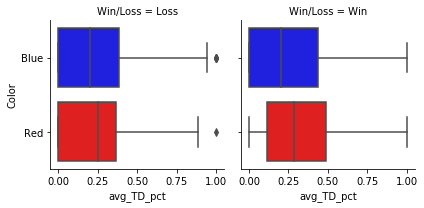

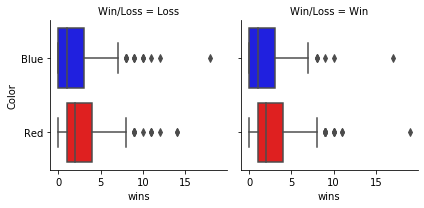

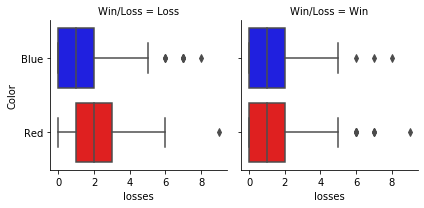

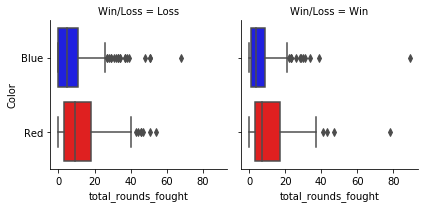

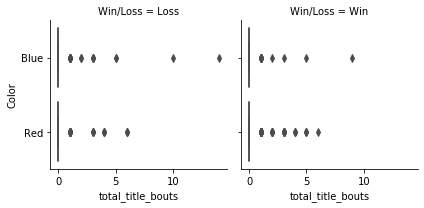

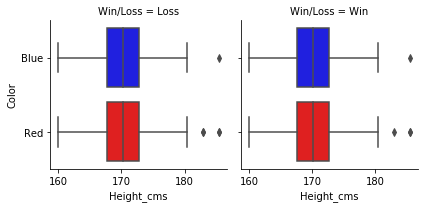

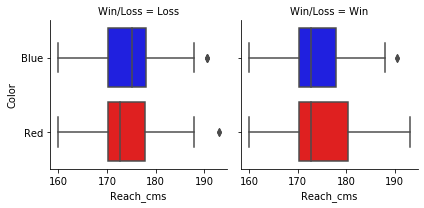

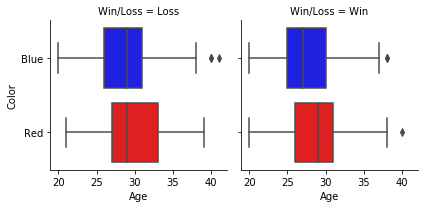

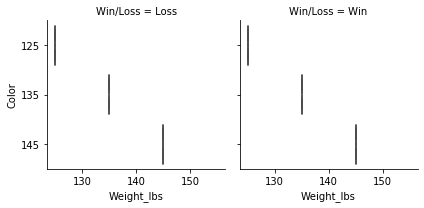

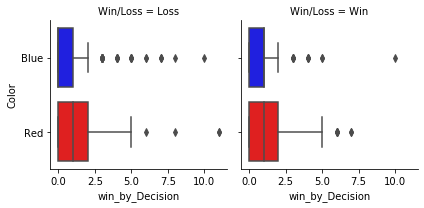

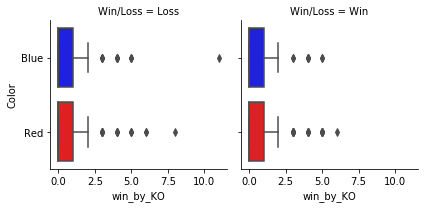

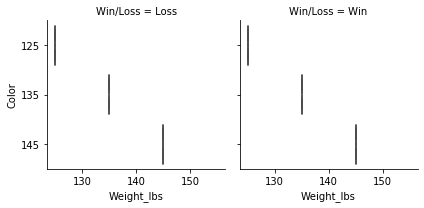

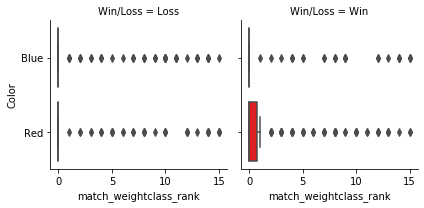

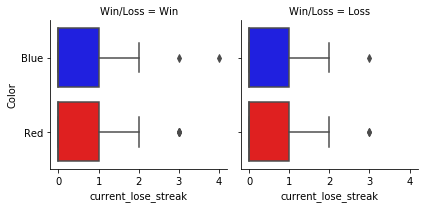

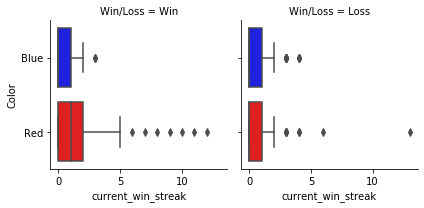

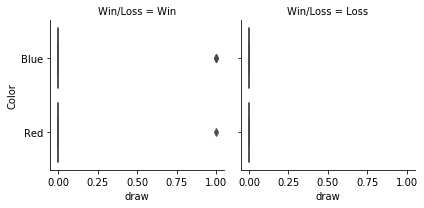

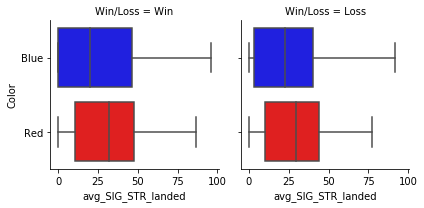

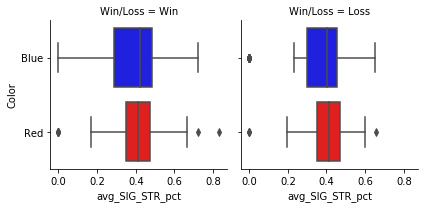

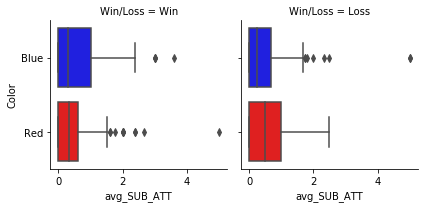

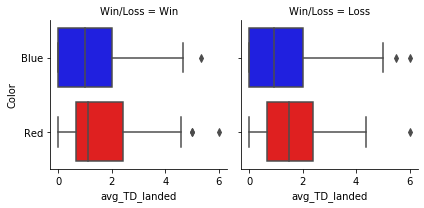

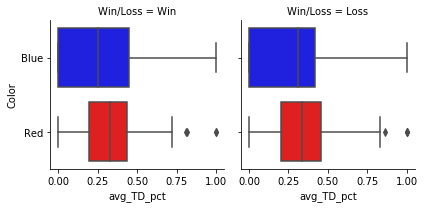

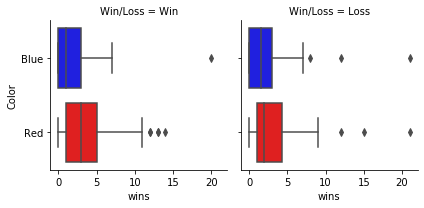

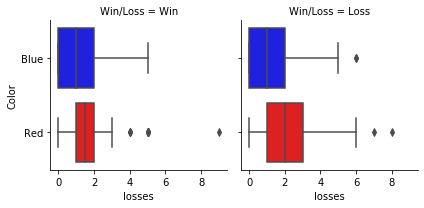

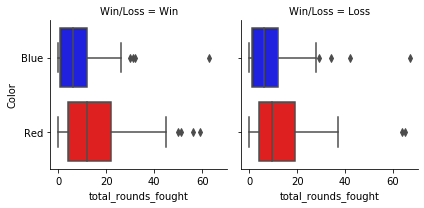

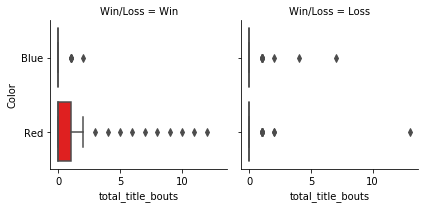

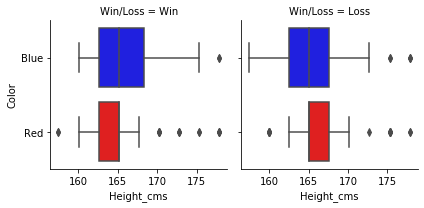

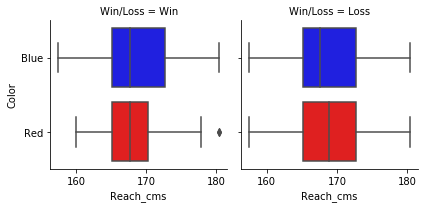

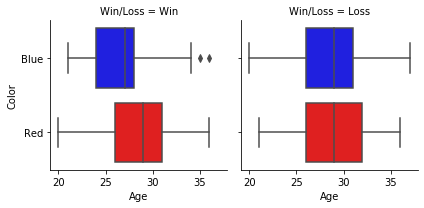

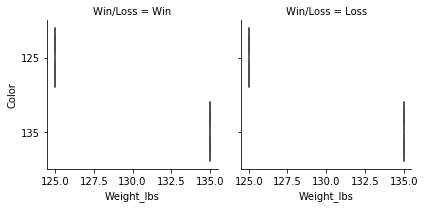

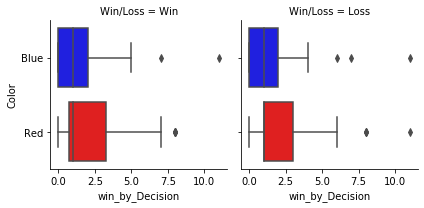

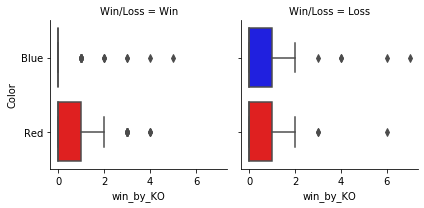

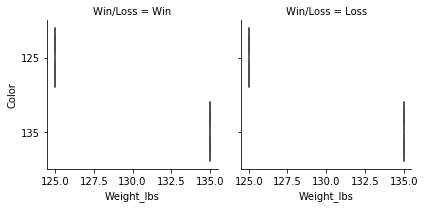

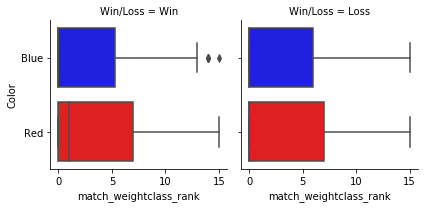

In [33]:
# Have the right order so disregarding the order warning
warnings.filterwarnings('ignore')
lw = m_winner_f[m_winner_f['weight_class'] == 'Lightweight']


# All Weight classes and vars per
for wc in m_weight_class:
    subset = m_winner_f[m_winner_f['weight_class'] == wc]
    for col in fighter_columns[2:]:
        g = sns.FacetGrid(subset, col='Win/Loss')
        g.map(sns.boxplot, col,'Color',palette=['#0000FF','#ff0000'], orient='h')

[Text(0.5, 0, 'current_lose_streak'),
 Text(1.5, 0, 'current_win_streak'),
 Text(2.5, 0, 'draw'),
 Text(3.5, 0, 'avg_SIG_STR_landed'),
 Text(4.5, 0, 'avg_SIG_STR_pct'),
 Text(5.5, 0, 'avg_SUB_ATT'),
 Text(6.5, 0, 'avg_TD_landed'),
 Text(7.5, 0, 'avg_TD_pct'),
 Text(8.5, 0, 'wins'),
 Text(9.5, 0, 'losses'),
 Text(10.5, 0, 'total_rounds_fought'),
 Text(11.5, 0, 'total_title_bouts'),
 Text(12.5, 0, 'Height_cms'),
 Text(13.5, 0, 'Reach_cms'),
 Text(14.5, 0, 'Age'),
 Text(15.5, 0, 'Weight_lbs'),
 Text(16.5, 0, 'win_by_Decision'),
 Text(17.5, 0, 'win_by_KO'),
 Text(18.5, 0, 'Weight_lbs'),
 Text(19.5, 0, 'match_weightclass_rank')]

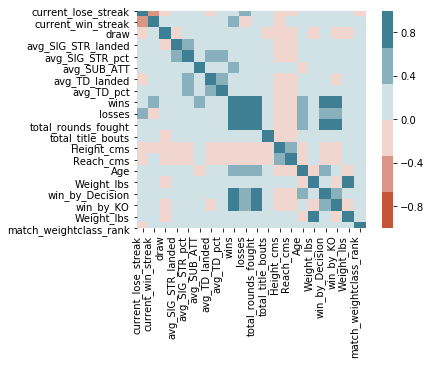

In [34]:
# Looking at relationship or variables: Lightweight Weight Class

m_lw = m_winner_f[m_winner_f['weight_class'] == 'Lightweight']
corr = m_lw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'current_lose_streak'),
 Text(1.5, 0, 'current_win_streak'),
 Text(2.5, 0, 'draw'),
 Text(3.5, 0, 'avg_SIG_STR_landed'),
 Text(4.5, 0, 'avg_SIG_STR_pct'),
 Text(5.5, 0, 'avg_SUB_ATT'),
 Text(6.5, 0, 'avg_TD_landed'),
 Text(7.5, 0, 'avg_TD_pct'),
 Text(8.5, 0, 'wins'),
 Text(9.5, 0, 'losses'),
 Text(10.5, 0, 'total_rounds_fought'),
 Text(11.5, 0, 'total_title_bouts'),
 Text(12.5, 0, 'Height_cms'),
 Text(13.5, 0, 'Reach_cms'),
 Text(14.5, 0, 'Age'),
 Text(15.5, 0, 'Weight_lbs'),
 Text(16.5, 0, 'win_by_Decision'),
 Text(17.5, 0, 'win_by_KO'),
 Text(18.5, 0, 'Weight_lbs'),
 Text(19.5, 0, 'match_weightclass_rank')]

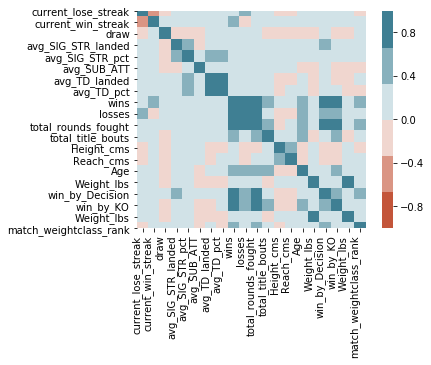

In [35]:
# Looking at relationship or variables: Middleweight Weight Class

m_mw = m_winner_f[m_winner_f['weight_class'] == 'Middleweight']
corr = m_mw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'current_lose_streak'),
 Text(1.5, 0, 'current_win_streak'),
 Text(2.5, 0, 'draw'),
 Text(3.5, 0, 'avg_SIG_STR_landed'),
 Text(4.5, 0, 'avg_SIG_STR_pct'),
 Text(5.5, 0, 'avg_SUB_ATT'),
 Text(6.5, 0, 'avg_TD_landed'),
 Text(7.5, 0, 'avg_TD_pct'),
 Text(8.5, 0, 'wins'),
 Text(9.5, 0, 'losses'),
 Text(10.5, 0, 'total_rounds_fought'),
 Text(11.5, 0, 'total_title_bouts'),
 Text(12.5, 0, 'Height_cms'),
 Text(13.5, 0, 'Reach_cms'),
 Text(14.5, 0, 'Age'),
 Text(15.5, 0, 'Weight_lbs'),
 Text(16.5, 0, 'win_by_Decision'),
 Text(17.5, 0, 'win_by_KO'),
 Text(18.5, 0, 'Weight_lbs'),
 Text(19.5, 0, 'match_weightclass_rank')]

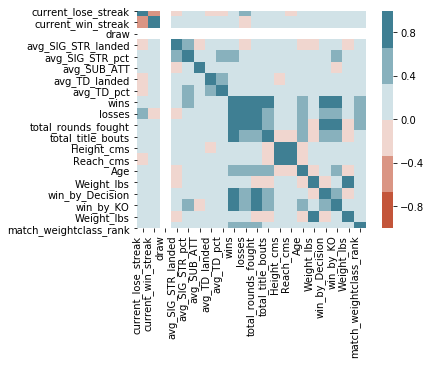

In [36]:
# Looking at relationship or variables: Heavyweight Weight Class

m_hw = m_winner_f[m_winner_f['weight_class'] == 'Heavyweight']
corr = m_hw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'current_lose_streak'),
 Text(1.5, 0, 'current_win_streak'),
 Text(2.5, 0, 'draw'),
 Text(3.5, 0, 'avg_SIG_STR_landed'),
 Text(4.5, 0, 'avg_SIG_STR_pct'),
 Text(5.5, 0, 'avg_SUB_ATT'),
 Text(6.5, 0, 'avg_TD_landed'),
 Text(7.5, 0, 'avg_TD_pct'),
 Text(8.5, 0, 'wins'),
 Text(9.5, 0, 'losses'),
 Text(10.5, 0, 'total_rounds_fought'),
 Text(11.5, 0, 'total_title_bouts'),
 Text(12.5, 0, 'Height_cms'),
 Text(13.5, 0, 'Reach_cms'),
 Text(14.5, 0, 'Age'),
 Text(15.5, 0, 'Weight_lbs'),
 Text(16.5, 0, 'win_by_Decision'),
 Text(17.5, 0, 'win_by_KO'),
 Text(18.5, 0, 'Weight_lbs'),
 Text(19.5, 0, 'match_weightclass_rank')]

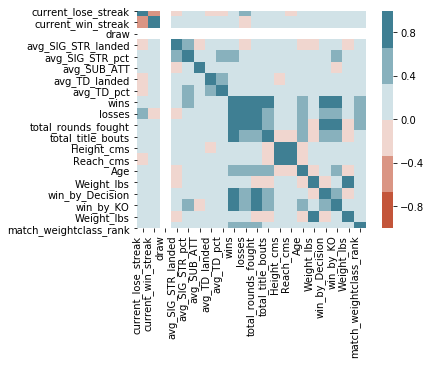

In [37]:
# Looking at relationship or variables: Heavyweight Weight Class

m_hw = m_winner_f[m_winner_f['weight_class'] == 'Heavyweight']
corr = m_hw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'current_lose_streak'),
 Text(1.5, 0, 'current_win_streak'),
 Text(2.5, 0, 'draw'),
 Text(3.5, 0, 'avg_SIG_STR_landed'),
 Text(4.5, 0, 'avg_SIG_STR_pct'),
 Text(5.5, 0, 'avg_SUB_ATT'),
 Text(6.5, 0, 'avg_TD_landed'),
 Text(7.5, 0, 'avg_TD_pct'),
 Text(8.5, 0, 'wins'),
 Text(9.5, 0, 'losses'),
 Text(10.5, 0, 'total_rounds_fought'),
 Text(11.5, 0, 'total_title_bouts'),
 Text(12.5, 0, 'Height_cms'),
 Text(13.5, 0, 'Reach_cms'),
 Text(14.5, 0, 'Age'),
 Text(15.5, 0, 'Weight_lbs'),
 Text(16.5, 0, 'win_by_Decision'),
 Text(17.5, 0, 'win_by_KO'),
 Text(18.5, 0, 'Weight_lbs'),
 Text(19.5, 0, 'match_weightclass_rank')]

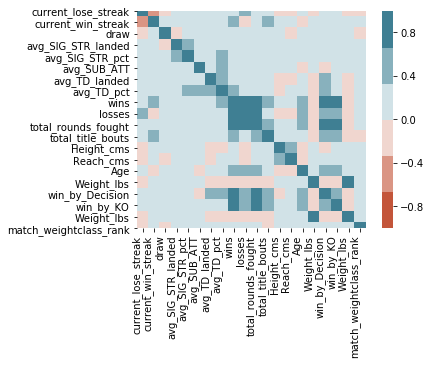

In [38]:
# Looking at relationship or variables: Light Heavyweight Weight Class

m_lhw = m_winner_f[m_winner_f['weight_class'] == 'Light Heavyweight']
corr = m_lhw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'current_lose_streak'),
 Text(1.5, 0, 'current_win_streak'),
 Text(2.5, 0, 'draw'),
 Text(3.5, 0, 'avg_SIG_STR_landed'),
 Text(4.5, 0, 'avg_SIG_STR_pct'),
 Text(5.5, 0, 'avg_SUB_ATT'),
 Text(6.5, 0, 'avg_TD_landed'),
 Text(7.5, 0, 'avg_TD_pct'),
 Text(8.5, 0, 'wins'),
 Text(9.5, 0, 'losses'),
 Text(10.5, 0, 'total_rounds_fought'),
 Text(11.5, 0, 'total_title_bouts'),
 Text(12.5, 0, 'Height_cms'),
 Text(13.5, 0, 'Reach_cms'),
 Text(14.5, 0, 'Age'),
 Text(15.5, 0, 'Weight_lbs'),
 Text(16.5, 0, 'win_by_Decision'),
 Text(17.5, 0, 'win_by_KO'),
 Text(18.5, 0, 'Weight_lbs'),
 Text(19.5, 0, 'match_weightclass_rank')]

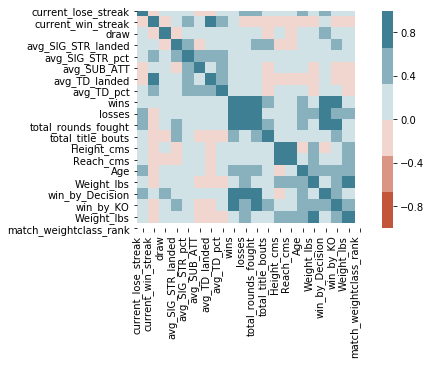

In [39]:
# Looking at relationship or variables: Catch Weight Weight Class

m_cw = m_winner_f[m_winner_f['weight_class'] == 'Catch Weight']
corr = m_cw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'current_lose_streak'),
 Text(1.5, 0, 'current_win_streak'),
 Text(2.5, 0, 'draw'),
 Text(3.5, 0, 'avg_SIG_STR_landed'),
 Text(4.5, 0, 'avg_SIG_STR_pct'),
 Text(5.5, 0, 'avg_SUB_ATT'),
 Text(6.5, 0, 'avg_TD_landed'),
 Text(7.5, 0, 'avg_TD_pct'),
 Text(8.5, 0, 'wins'),
 Text(9.5, 0, 'losses'),
 Text(10.5, 0, 'total_rounds_fought'),
 Text(11.5, 0, 'total_title_bouts'),
 Text(12.5, 0, 'Height_cms'),
 Text(13.5, 0, 'Reach_cms'),
 Text(14.5, 0, 'Age'),
 Text(15.5, 0, 'Weight_lbs'),
 Text(16.5, 0, 'win_by_Decision'),
 Text(17.5, 0, 'win_by_KO'),
 Text(18.5, 0, 'Weight_lbs'),
 Text(19.5, 0, 'match_weightclass_rank')]

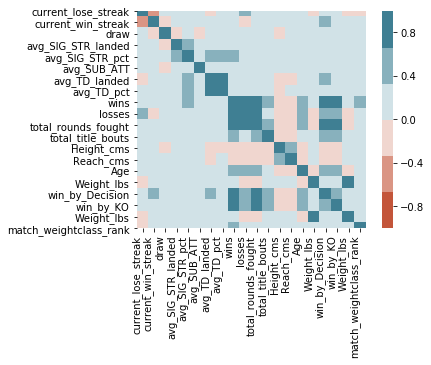

In [40]:
# Looking at relationship or variables: Welterweight Weight Class

m_ww = m_winner_f[m_winner_f['weight_class'] == 'Welterweight']
corr = m_ww.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'current_lose_streak'),
 Text(1.5, 0, 'current_win_streak'),
 Text(2.5, 0, 'draw'),
 Text(3.5, 0, 'avg_SIG_STR_landed'),
 Text(4.5, 0, 'avg_SIG_STR_pct'),
 Text(5.5, 0, 'avg_SUB_ATT'),
 Text(6.5, 0, 'avg_TD_landed'),
 Text(7.5, 0, 'avg_TD_pct'),
 Text(8.5, 0, 'wins'),
 Text(9.5, 0, 'losses'),
 Text(10.5, 0, 'total_rounds_fought'),
 Text(11.5, 0, 'total_title_bouts'),
 Text(12.5, 0, 'Height_cms'),
 Text(13.5, 0, 'Reach_cms'),
 Text(14.5, 0, 'Age'),
 Text(15.5, 0, 'Weight_lbs'),
 Text(16.5, 0, 'win_by_Decision'),
 Text(17.5, 0, 'win_by_KO'),
 Text(18.5, 0, 'Weight_lbs'),
 Text(19.5, 0, 'match_weightclass_rank')]

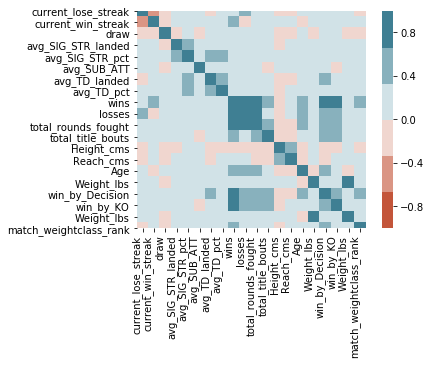

In [41]:
# Looking at relationship or variables: Featherweight Weight Class

m_fw = m_winner_f[m_winner_f['weight_class'] == 'Featherweight']
corr = m_fw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'current_lose_streak'),
 Text(1.5, 0, 'current_win_streak'),
 Text(2.5, 0, 'draw'),
 Text(3.5, 0, 'avg_SIG_STR_landed'),
 Text(4.5, 0, 'avg_SIG_STR_pct'),
 Text(5.5, 0, 'avg_SUB_ATT'),
 Text(6.5, 0, 'avg_TD_landed'),
 Text(7.5, 0, 'avg_TD_pct'),
 Text(8.5, 0, 'wins'),
 Text(9.5, 0, 'losses'),
 Text(10.5, 0, 'total_rounds_fought'),
 Text(11.5, 0, 'total_title_bouts'),
 Text(12.5, 0, 'Height_cms'),
 Text(13.5, 0, 'Reach_cms'),
 Text(14.5, 0, 'Age'),
 Text(15.5, 0, 'Weight_lbs'),
 Text(16.5, 0, 'win_by_Decision'),
 Text(17.5, 0, 'win_by_KO'),
 Text(18.5, 0, 'Weight_lbs'),
 Text(19.5, 0, 'match_weightclass_rank')]

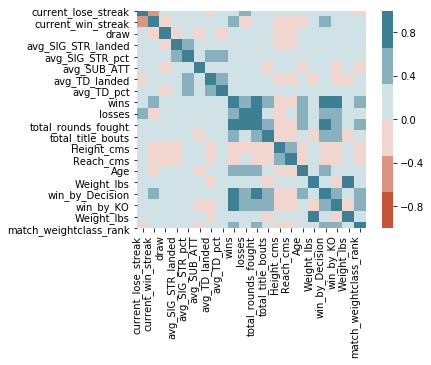

In [42]:
# Looking at relationship or variables: Bantamweight Weight Class

m_bw = m_winner_f[m_winner_f['weight_class'] == 'Bantamweight']
corr = m_bw.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

[Text(0.5, 0, 'current_lose_streak'),
 Text(1.5, 0, 'current_win_streak'),
 Text(2.5, 0, 'draw'),
 Text(3.5, 0, 'avg_SIG_STR_landed'),
 Text(4.5, 0, 'avg_SIG_STR_pct'),
 Text(5.5, 0, 'avg_SUB_ATT'),
 Text(6.5, 0, 'avg_TD_landed'),
 Text(7.5, 0, 'avg_TD_pct'),
 Text(8.5, 0, 'wins'),
 Text(9.5, 0, 'losses'),
 Text(10.5, 0, 'total_rounds_fought'),
 Text(11.5, 0, 'total_title_bouts'),
 Text(12.5, 0, 'Height_cms'),
 Text(13.5, 0, 'Reach_cms'),
 Text(14.5, 0, 'Age'),
 Text(15.5, 0, 'Weight_lbs'),
 Text(16.5, 0, 'win_by_Decision'),
 Text(17.5, 0, 'win_by_KO'),
 Text(18.5, 0, 'Weight_lbs'),
 Text(19.5, 0, 'match_weightclass_rank')]

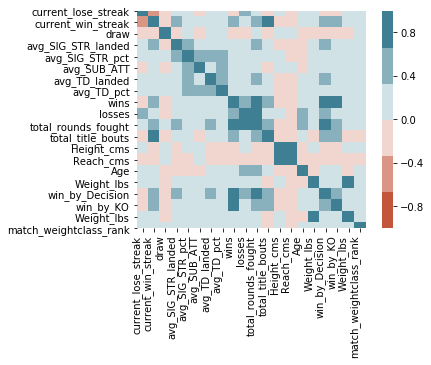

In [43]:
# Looking at relationship or variables: Fly Weight Class

m_fly = m_winner_f[m_winner_f['weight_class'] == 'Flyweight']
corr = m_fly.corr()
ax = sns.heatmap(
corr,
vmin=-1, vmax=1, center =0,
cmap=sns.diverging_palette(20,220),
square=True)
ax.set_xticklabels(
ax.get_xticklabels(),
rotation=90,
horizontalalignment='right')

In [44]:
# Prepping Model Data


# Features and yhat
m_winner_features = m_winner_difs.drop(['Winner'], axis = 1)
m_winner_yhat = m_winner_difs[['Winner','weight_class']]


# Normalizing the features
#m_winner_features_norm = preprocessing.normalize(m_winner_features)
# Make it into a dataframe so you concat with another easily
#m_winner_features_norm = pd.DataFrame(m_winner_features_norm, columns = m_winner_features.columns, index=m_winner_features.index)

# Read weight class so it is easy to iterate
#m_winner_features_norm = pd.concat([m_winner_features_norm,m_winner_difs[['weight_class']]],axis=1)

In [45]:
# Should be averaging the values and excluding the columns that do not require a second glance -- i.e. winner and gender
# Might not want to use differences, but rather averages across to represent this data better.

### Decision Trees:

In [46]:
depth = 10

for wc in m_weight_class:
    
    # Each set per weight class
    features_sub = m_winner_features[m_winner_features['weight_class'] == wc]
    yhat_sub = m_winner_yhat[m_winner_yhat['weight_class'] == wc]
    
    # Drop weight class, you don't need it anymore
    features_sub = features_sub.drop(['weight_class'], axis = 1)
    yhat_sub = yhat_sub.drop(['weight_class'], axis = 1)
    
    # Split data into training and test data
    x_train, x_test, y_train, y_test = train_test_split(features_sub, yhat_sub, test_size = .2, random_state = 32)
    
    # Scaling features
    x_train = preprocessing.normalize(x_train)
    x_test = preprocessing.normalize(x_test)
    
    for d in range(1,depth):
        winner_tree_m = DecisionTreeClassifier(criterion='entropy',max_depth = depth)
        winner_tree_m.fit(x_train, y_train)
        winner_tree_yhat_m = winner_tree_m.predict(x_test)
        print(wc,"Decision Tree's Accuracy: ", metrics.accuracy_score(y_test, winner_tree_yhat_m),'F1: ', f1_score(y_test,winner_tree_yhat_m, average = 'weighted'),'Train Set: ', x_train.shape, y_train.shape,', Test Set: ',x_test.shape,y_test.shape, depth)

Lightweight Decision Tree's Accuracy:  0.5714285714285714 F1:  0.5366688610928242 Train Set:  (642, 17) (642, 1) , Test Set:  (161, 17) (161, 1) 10
Lightweight Decision Tree's Accuracy:  0.5652173913043478 F1:  0.5280522230063514 Train Set:  (642, 17) (642, 1) , Test Set:  (161, 17) (161, 1) 10
Lightweight Decision Tree's Accuracy:  0.5590062111801242 F1:  0.5335870738714341 Train Set:  (642, 17) (642, 1) , Test Set:  (161, 17) (161, 1) 10
Lightweight Decision Tree's Accuracy:  0.5590062111801242 F1:  0.5303626037570992 Train Set:  (642, 17) (642, 1) , Test Set:  (161, 17) (161, 1) 10
Lightweight Decision Tree's Accuracy:  0.5652173913043478 F1:  0.5240641711229946 Train Set:  (642, 17) (642, 1) , Test Set:  (161, 17) (161, 1) 10
Lightweight Decision Tree's Accuracy:  0.5590062111801242 F1:  0.5151458908011034 Train Set:  (642, 17) (642, 1) , Test Set:  (161, 17) (161, 1) 10
Lightweight Decision Tree's Accuracy:  0.5652173913043478 F1:  0.5280522230063514 Train Set:  (642, 17) (642, 1)

### Decision Tree Tuning:
* F1 and Jaccard
* General Tuning

### K Nearest Neighbor (KNN):

In [52]:
Ks = 10

for wc in m_weight_class:
    features_sub = m_winner_features[m_winner_features['weight_class'] == wc]
    yhat_sub = m_winner_yhat[m_winner_yhat['weight_class'] == wc]
    
    
    features_sub = features_sub.drop(['weight_class'], axis = 1)
    yhat_sub = yhat_sub.drop(['weight_class'], axis = 1)
    
    # Split data into training and test
    x_train, x_test, y_train, y_test = train_test_split(features_sub, yhat_sub, test_size = .2, random_state = 32)
    
    # Scaling features
    x_train = preprocessing.normalize(x_train)
    x_test = preprocessing.normalize(x_test)
    
    # To process 1-D Arrays instead of column vectors
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    
    
    for k in range(1,Ks):
        
        winner_knn_m = KNeighborsClassifier(n_neighbors = k).fit(x_train, y_train)
        winner_knn_yhat_m = winner_knn_m.predict(x_test)
        print(wc,"KNN's Accuracy: ", metrics.accuracy_score(y_test, winner_knn_yhat_m),'F1: ', f1_score(y_test,winner_knn_yhat_m, average = 'weighted'), ',Train Set: ', x_train.shape, y_train.shape,', Test Set: ',x_test.shape,y_test.shape, k)

Lightweight KNN's Accuracy:  0.5341614906832298 F1:  0.5315670127700203 ,Train Set:  (642, 17) (642,) , Test Set:  (161, 17) (161,) 1


ValueError: Found input variables with inconsistent numbers of samples: [161, 642]

### K Nearest Neighbor Tuning (KNN):
* F1 and Jaccard
* General Tuning

### Logistic Regression:

In [48]:
for wc in m_weight_class:
    
    features_sub = m_winner_features[m_winner_features['weight_class'] == wc]
    yhat_sub = m_winner_yhat[m_winner_yhat['weight_class'] == wc]
    
    features_sub = features_sub.drop(['weight_class'], axis = 1)
    yhat_sub = yhat_sub.drop(['weight_class'], axis = 1)
    
    
    x_train, x_test, y_train, y_test = train_test_split(features_sub, yhat_sub, test_size = .2, random_state = 32)
    
    # Scaling features
    x_train = preprocessing.normalize(x_train)
    x_test = preprocessing.normalize(x_test)
    
    
    # To process 1-D Arrays instead of column vectors
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    
    winner_loglin_m = LogisticRegression(C=0.01, solver = 'liblinear')
    winner_loglin_m.fit(x_train, y_train)
    winner_loglin_yhat_m = winner_loglin_m.predict(x_test)
    winner_loglin_prob_m = winner_loglin_m.predict_proba(x_test)
    print(wc,"Decision Tree's Accuracy: ", metrics.accuracy_score(y_test, winner_loglin_yhat_m),'Log-Loss ', log_loss(y_test, winner_loglin_prob_m),'Train Set: ', x_train.shape, y_train.shape,', Test Set: ',x_test.shape,y_test.shape)

Lightweight Decision Tree's Accuracy:  0.5714285714285714 Log-Loss  0.6817724538697705 Train Set:  (642, 17) (642,) , Test Set:  (161, 17) (161,)
Middleweight Decision Tree's Accuracy:  0.6542056074766355 Log-Loss  0.6800454883995793 Train Set:  (428, 17) (428,) , Test Set:  (107, 17) (107,)
Heavyweight Decision Tree's Accuracy:  0.6 Log-Loss  0.6759046587048116 Train Set:  (277, 17) (277,) , Test Set:  (70, 17) (70,)
Light Heavyweight Decision Tree's Accuracy:  0.5205479452054794 Log-Loss  0.6874484509851614 Train Set:  (288, 17) (288,) , Test Set:  (73, 17) (73,)
Catch Weight Decision Tree's Accuracy:  0.5 Log-Loss  0.6898781962161037 Train Set:  (20, 17) (20,) , Test Set:  (6, 17) (6,)
Welterweight Decision Tree's Accuracy:  0.5548387096774193 Log-Loss  0.686485734602746 Train Set:  (617, 17) (617,) , Test Set:  (155, 17) (155,)
Featherweight Decision Tree's Accuracy:  0.6442307692307693 Log-Loss  0.6660907638471016 Train Set:  (413, 17) (413,) , Test Set:  (104, 17) (104,)
Bantamwe

### Logistic Regression Tuning:
* F1, Jaccard, and LogLoss
* General Tuning

### Support Vector Machine (SVM):

In [49]:
for wc in m_weight_class:
    
    features_sub = m_winner_features[m_winner_features['weight_class'] == wc]
    yhat_sub = m_winner_yhat[m_winner_yhat['weight_class'] == wc]
    
    features_sub = features_sub.drop(['weight_class'], axis = 1)
    yhat_sub = yhat_sub.drop(['weight_class'], axis = 1)
    
    
    x_train, x_test, y_train, y_test = train_test_split(features_sub, yhat_sub, test_size = .2, random_state = 32)
    
    # Scaling features
    x_train = preprocessing.normalize(x_train)
    x_test = preprocessing.normalize(x_test)
    
    # To process 1-D Arrays instead of column vectors
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)
    
    winner_svm_m = svm.SVC(gamma='auto')
    winner_svm_m.fit(x_train, y_train)
    winner_svm_yhat_m = winner_svm_m.predict(x_test)
    print(wc,"Decision Tree's Accuracy: ", metrics.accuracy_score(y_test, winner_svm_yhat_m),'F1: ', f1_score(y_test,winner_svm_yhat_m, average = 'weighted'), ',Train Set: ', x_train.shape, y_train.shape,', Test Set: ',x_test.shape,y_test.shape)

Lightweight Decision Tree's Accuracy:  0.5714285714285714 F1:  0.41558441558441556 ,Train Set:  (642, 17) (642,) , Test Set:  (161, 17) (161,)
Middleweight Decision Tree's Accuracy:  0.6355140186915887 F1:  0.49388518024032035 ,Train Set:  (428, 17) (428,) , Test Set:  (107, 17) (107,)
Heavyweight Decision Tree's Accuracy:  0.6 F1:  0.44999999999999996 ,Train Set:  (277, 17) (277,) , Test Set:  (70, 17) (70,)
Light Heavyweight Decision Tree's Accuracy:  0.5205479452054794 F1:  0.3564112057262742 ,Train Set:  (288, 17) (288,) , Test Set:  (73, 17) (73,)
Catch Weight Decision Tree's Accuracy:  0.6666666666666666 F1:  0.5333333333333333 ,Train Set:  (20, 17) (20,) , Test Set:  (6, 17) (6,)
Welterweight Decision Tree's Accuracy:  0.5548387096774193 F1:  0.39598447329674746 ,Train Set:  (617, 17) (617,) , Test Set:  (155, 17) (155,)
Featherweight Decision Tree's Accuracy:  0.6442307692307693 F1:  0.5048358074673864 ,Train Set:  (413, 17) (413,) , Test Set:  (104, 17) (104,)
Bantamweight Dec

### Support Vector Machine (SVM) Tuning:
* F1 and Jaccard
* General Tuning

## Winner Model Summary Report:
* Summarize The best model for each weight class
* Highlight some standouts

# Method of Victory:
* Utilizes multi-class classfication models

# Round Win:
* Utilizes multi-class/multi output classification models